In [1]:

import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

In [2]:
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")
OUT_DIR.mkdir(parents=True, exist_ok=True)


Processing S01E01


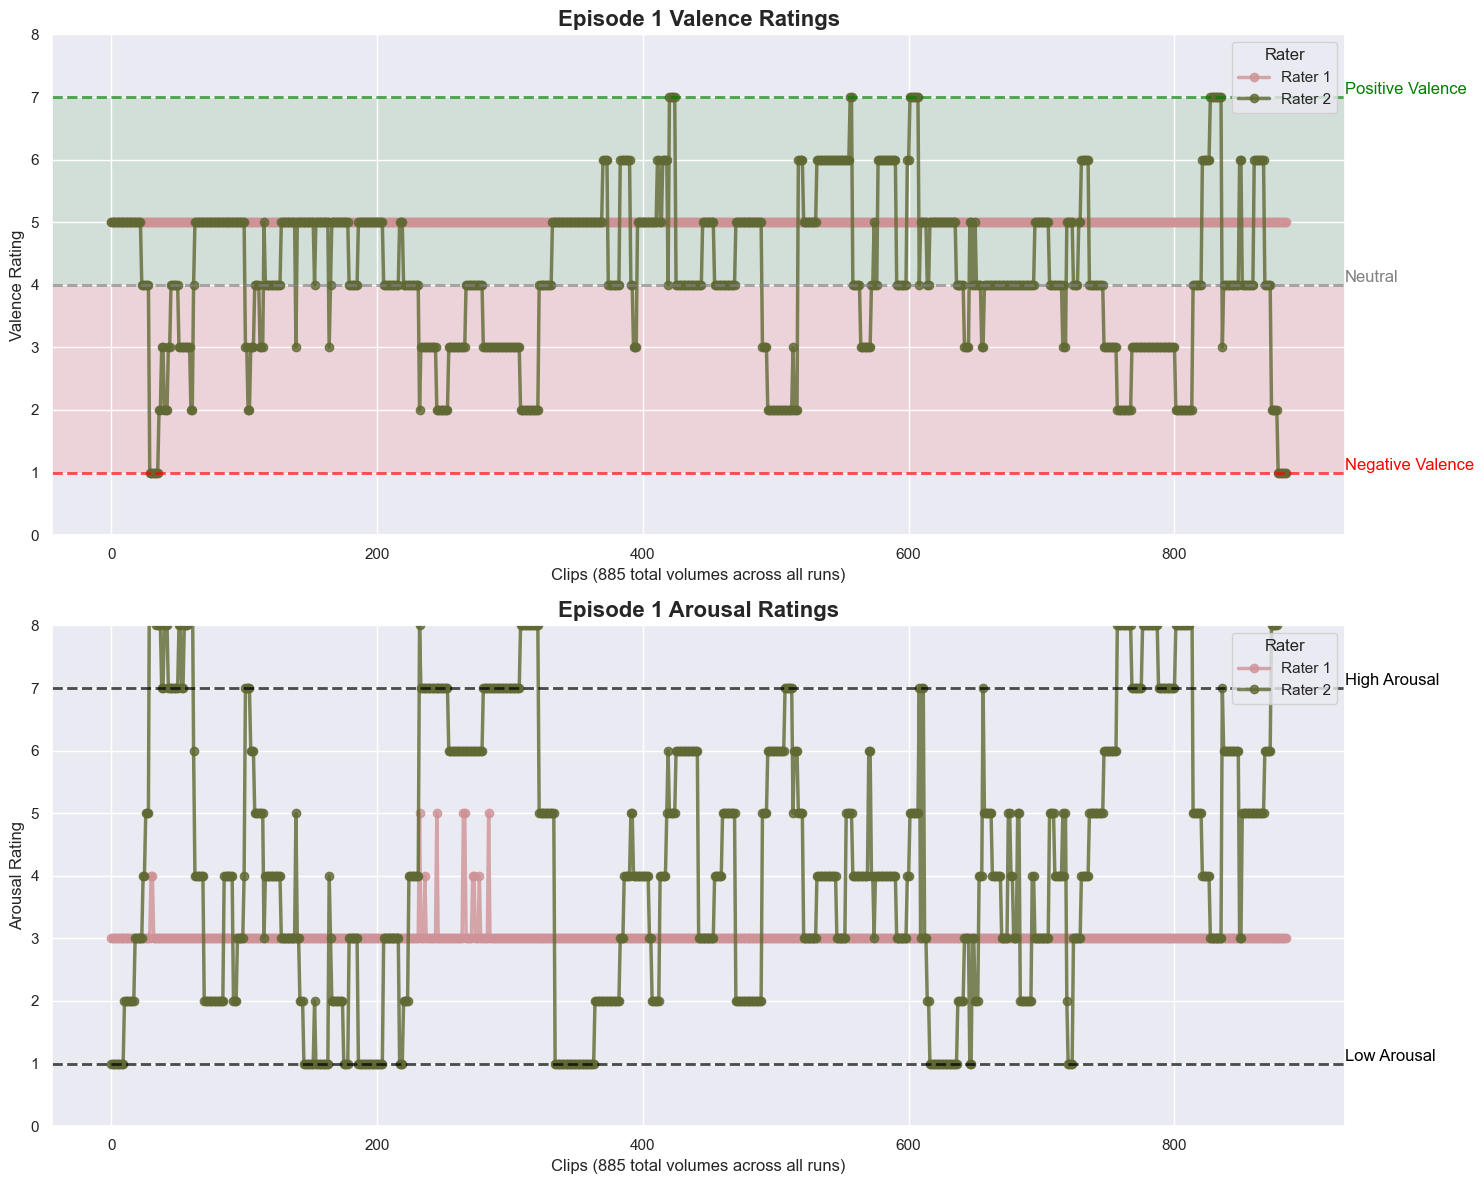

Sequential position range: 0 - 884
Total clips: 885
Number of runs: 3

Processing S01E02


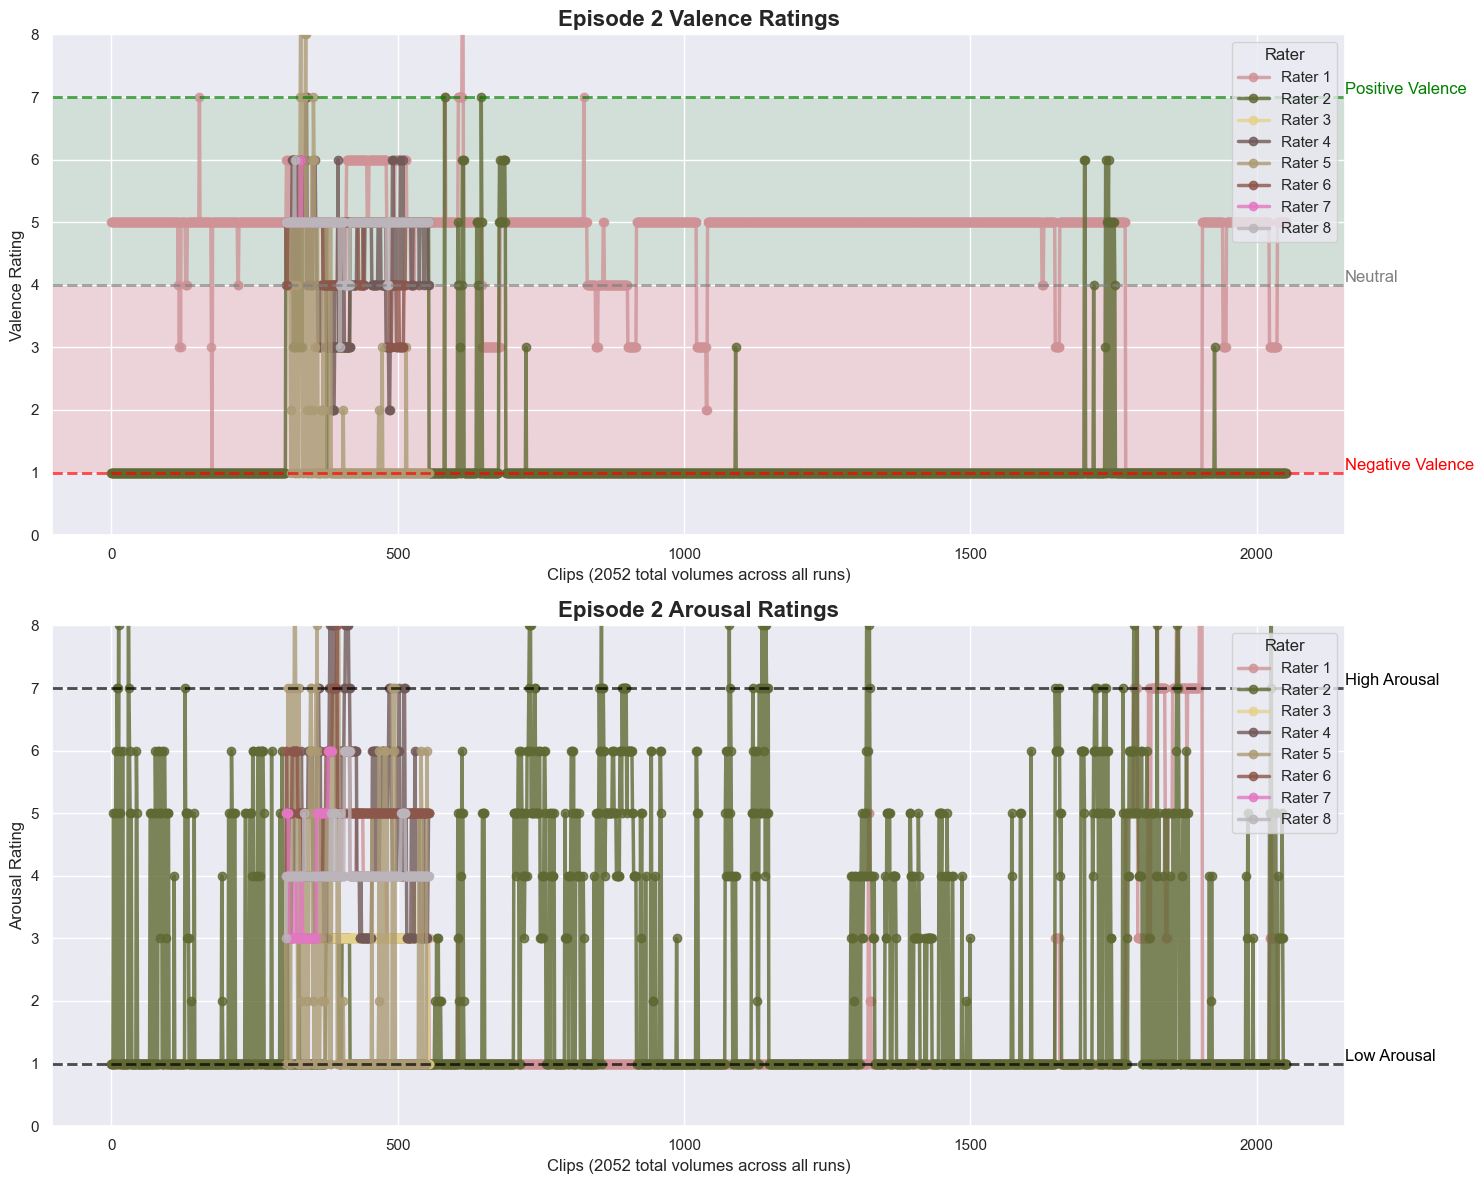

Sequential position range: 0 - 2051
Total clips: 2052
Number of runs: 7

Processing S01E03


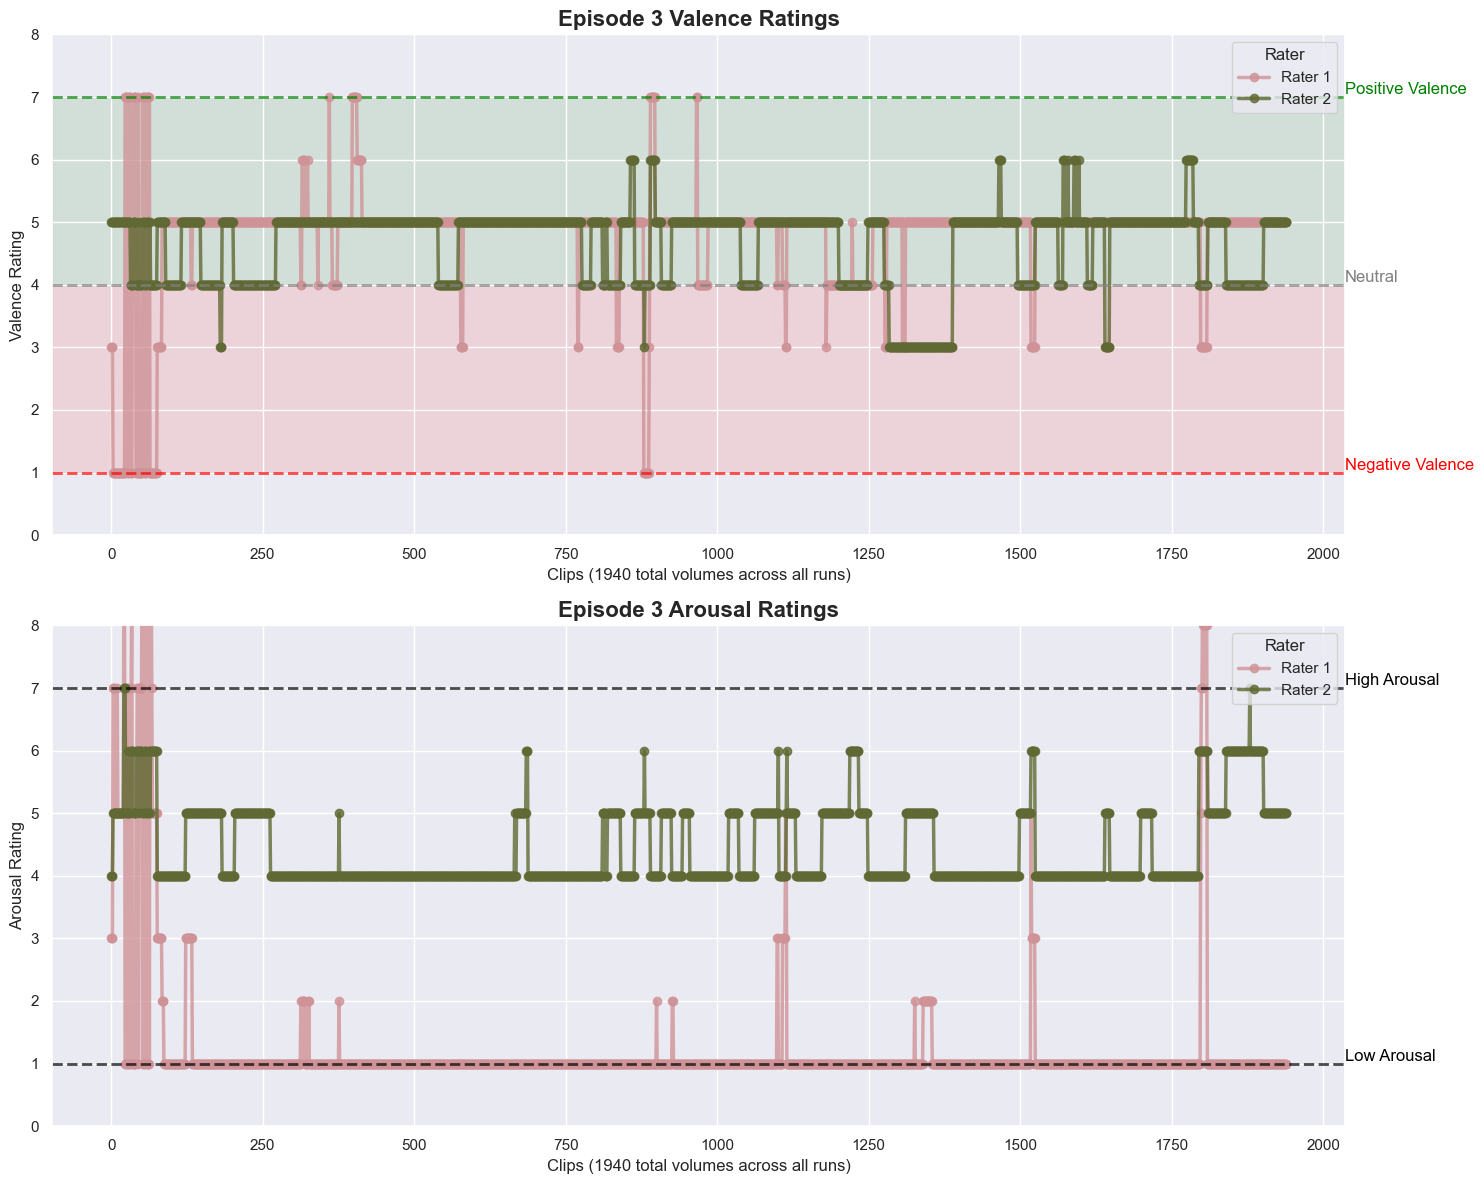

Sequential position range: 0 - 1939
Total clips: 1940
Number of runs: 6

Processing S01E04


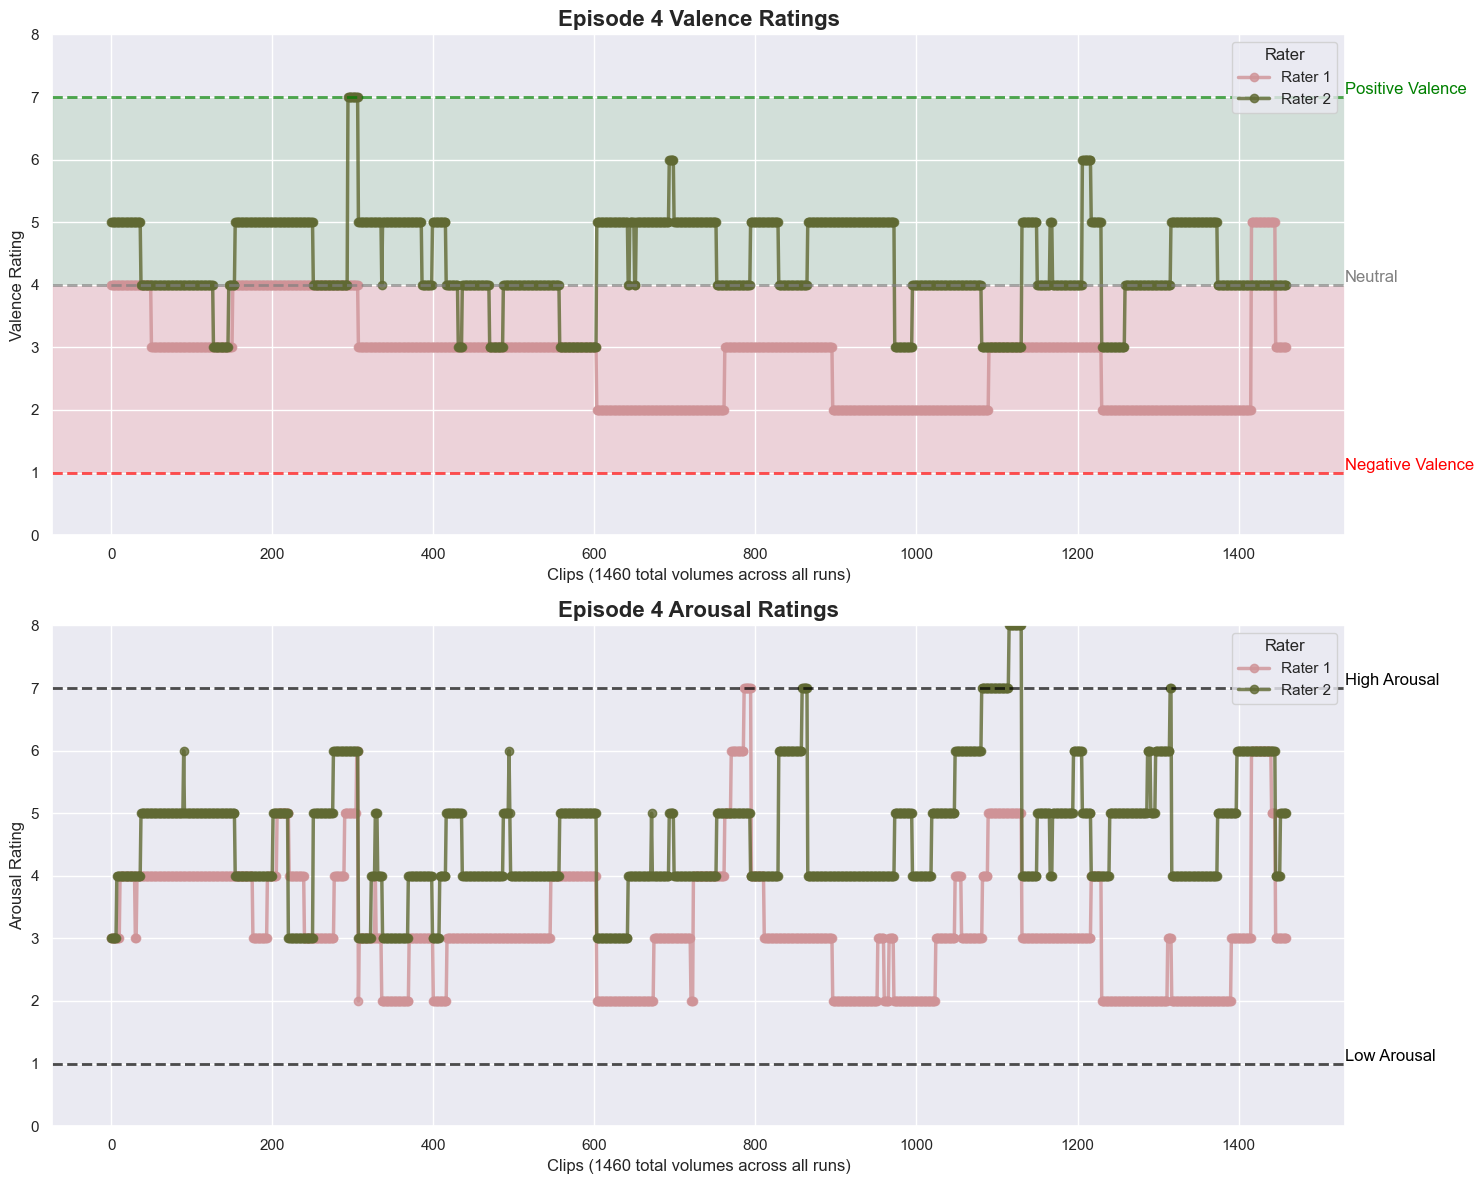

Sequential position range: 0 - 1459
Total clips: 1460
Number of runs: 5

All episode plots completed!


In [3]:
import re
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define colors for consistent plotting
colors = ['#CF9397', "#606933", '#E5D28E', '#715958', '#AC9B74', '#8c564b', '#e377c2', '#BCB5BB']

# Find all episode CSV files
episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Processing {episode_name}")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # ---- Make LONG data with rater column ----
    # Valence: columns valence_1, valence_2 -> rows with rater=1/2
    valence_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=val_cols,
        var_name='rater',
        value_name='valence'
    )
    valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
    arousal_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=aro_cols,
        var_name='rater',
        value_name='arousal'
    )
    arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    total_trs = len(episode_df)

    # Valence plot
    if not valence_long.empty:
        ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
        ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(valence_long['rater'].unique())):
            rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
            ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax1.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.set_ylim(0, 8)
        ax1.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax1.get_xlim()[1]
        ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
        ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
        ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
    else:
        ax1.set_title('No valence columns found')

    # Arousal plot
    if not arousal_long.empty:
        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
            rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
            ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax2.set_title(f'Episode {ep_num} Arousal Ratings', fontsize=16, fontweight='bold')
        ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.set_ylim(0, 8)
        ax2.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax2.get_xlim()[1]
        ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
        ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
    else:
        ax2.set_title('No arousal columns found')

    plt.tight_layout()
    plt.show()

    print(f"Sequential position range: 0 - {len(episode_df)-1}")
    print(f"Total clips: {len(episode_df)}")
    print(f"Number of runs: {episode_df['run_number'].nunique()}")

print(f"\n{'='*60}")
print("All episode plots completed!")
print(f"{'='*60}")


Processing S01E01 - Additional Plot


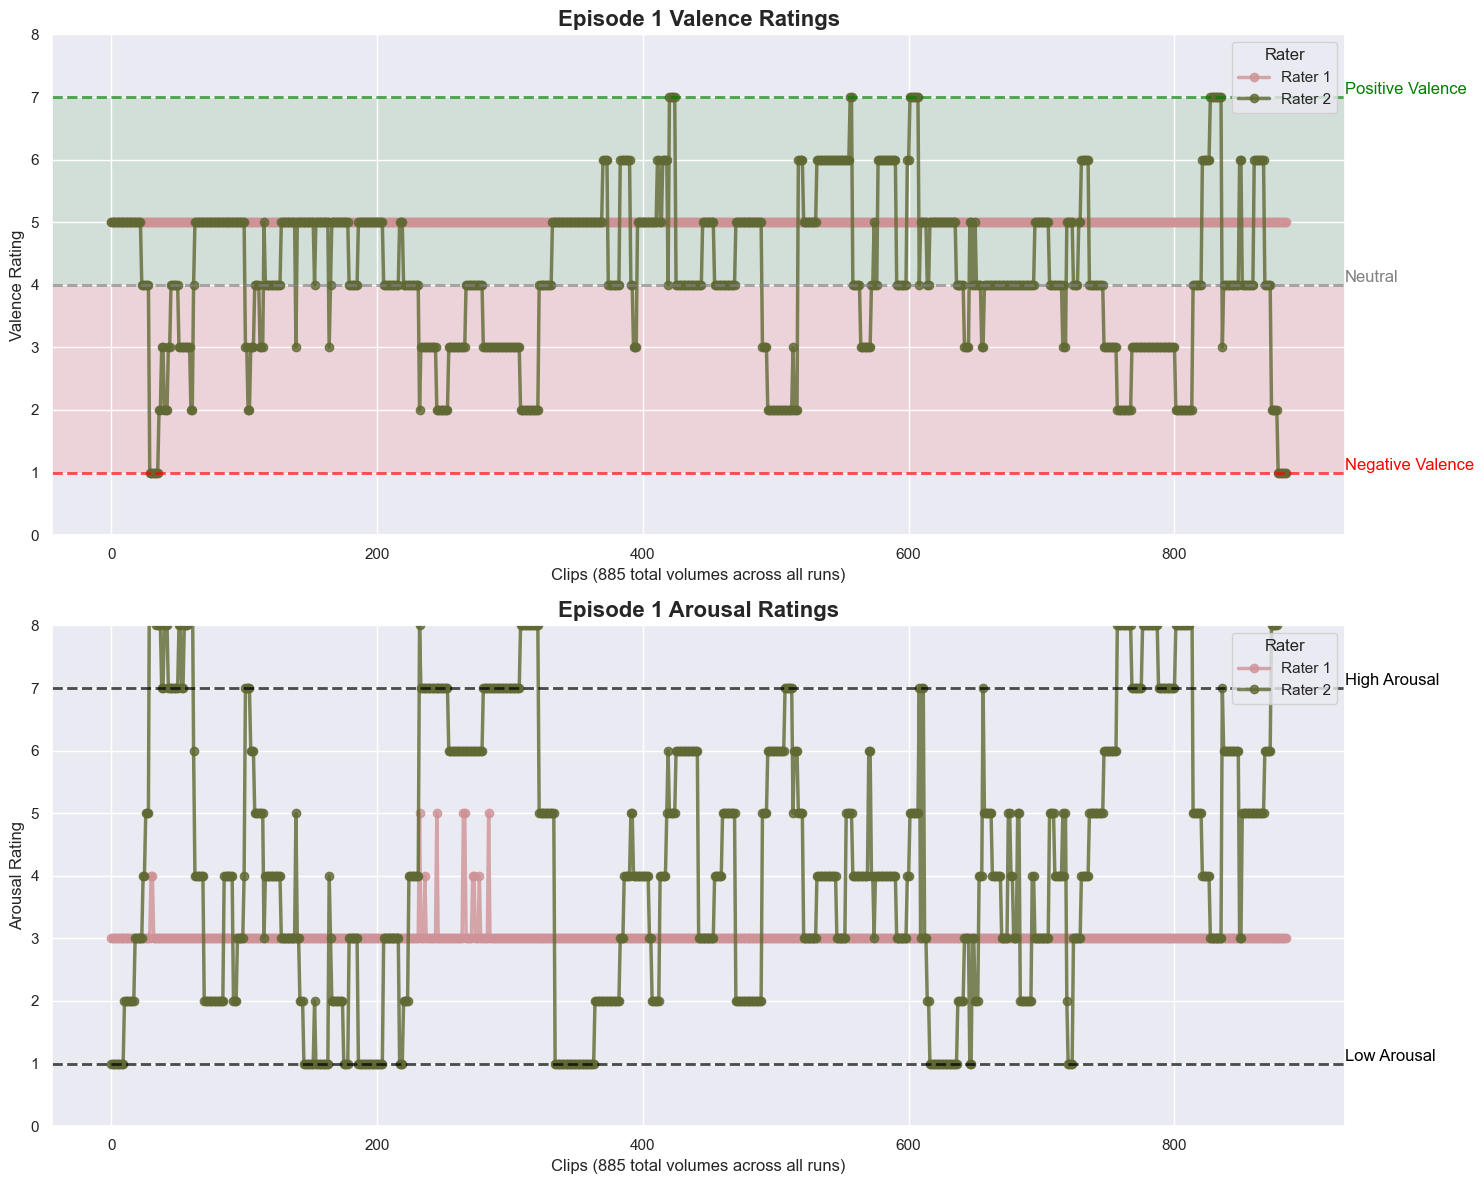

Sequential position range: 0 - 884
Total clips: 885
Number of runs: 3

Processing S01E02 - Additional Plot


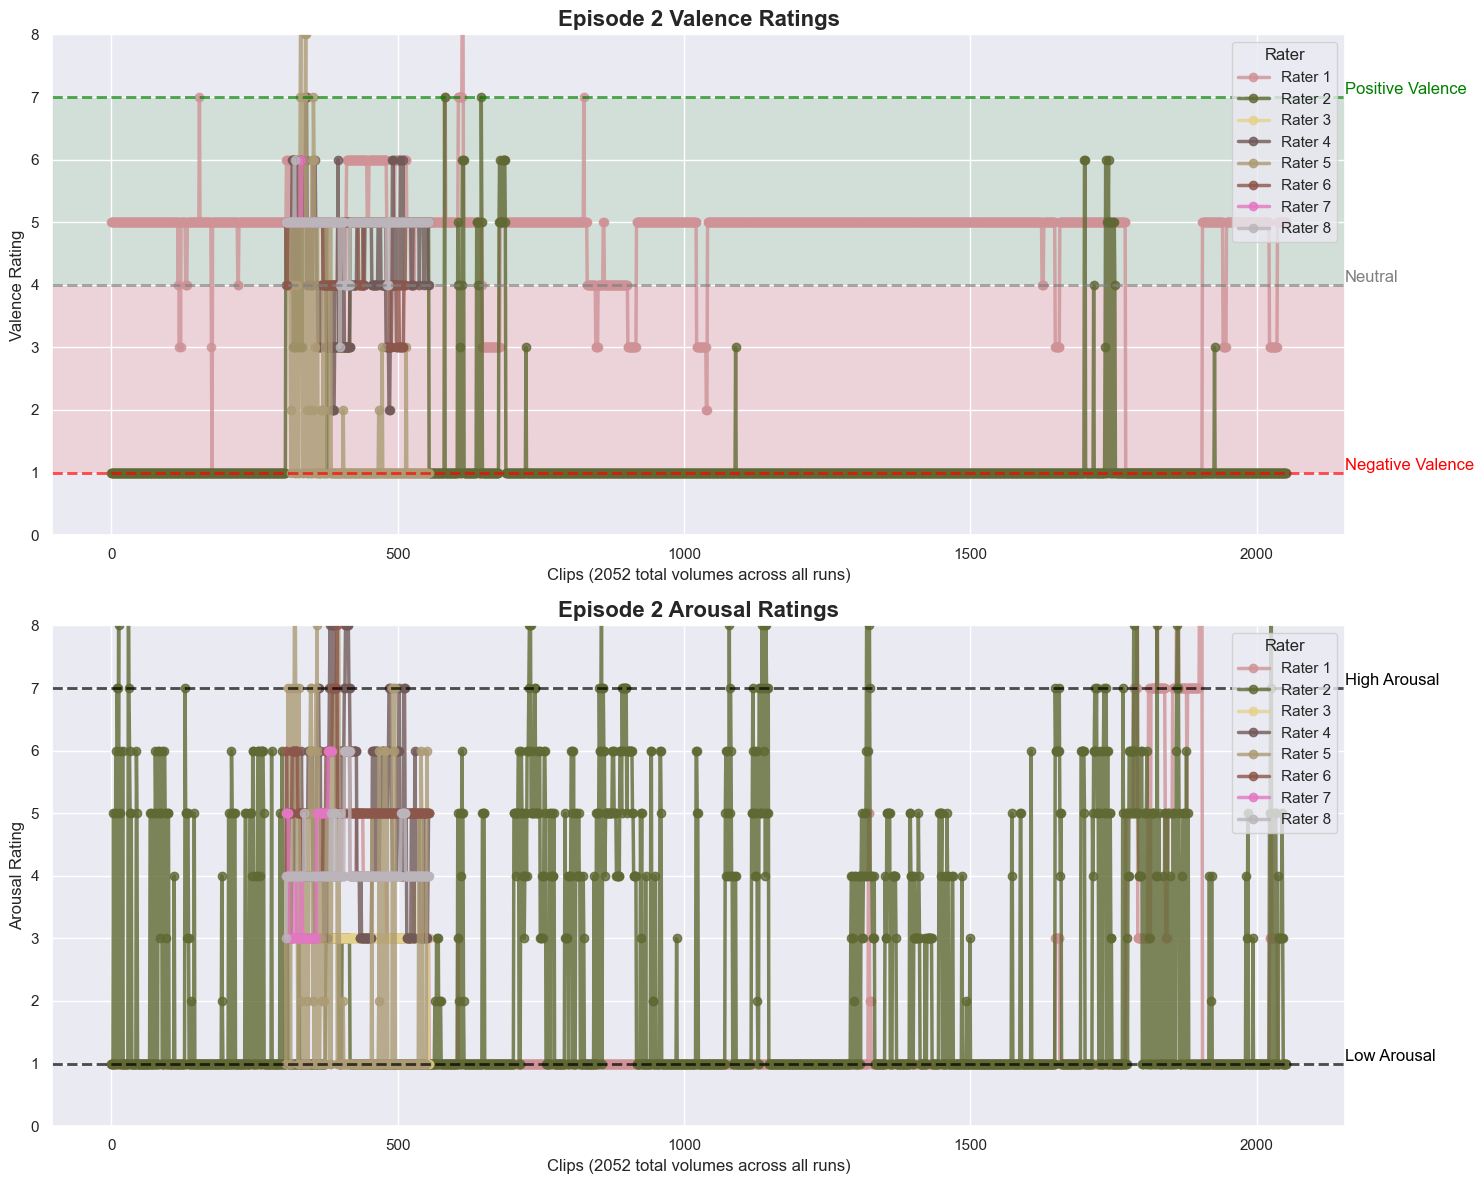

Sequential position range: 0 - 2051
Total clips: 2052
Number of runs: 7

Processing S01E03 - Additional Plot


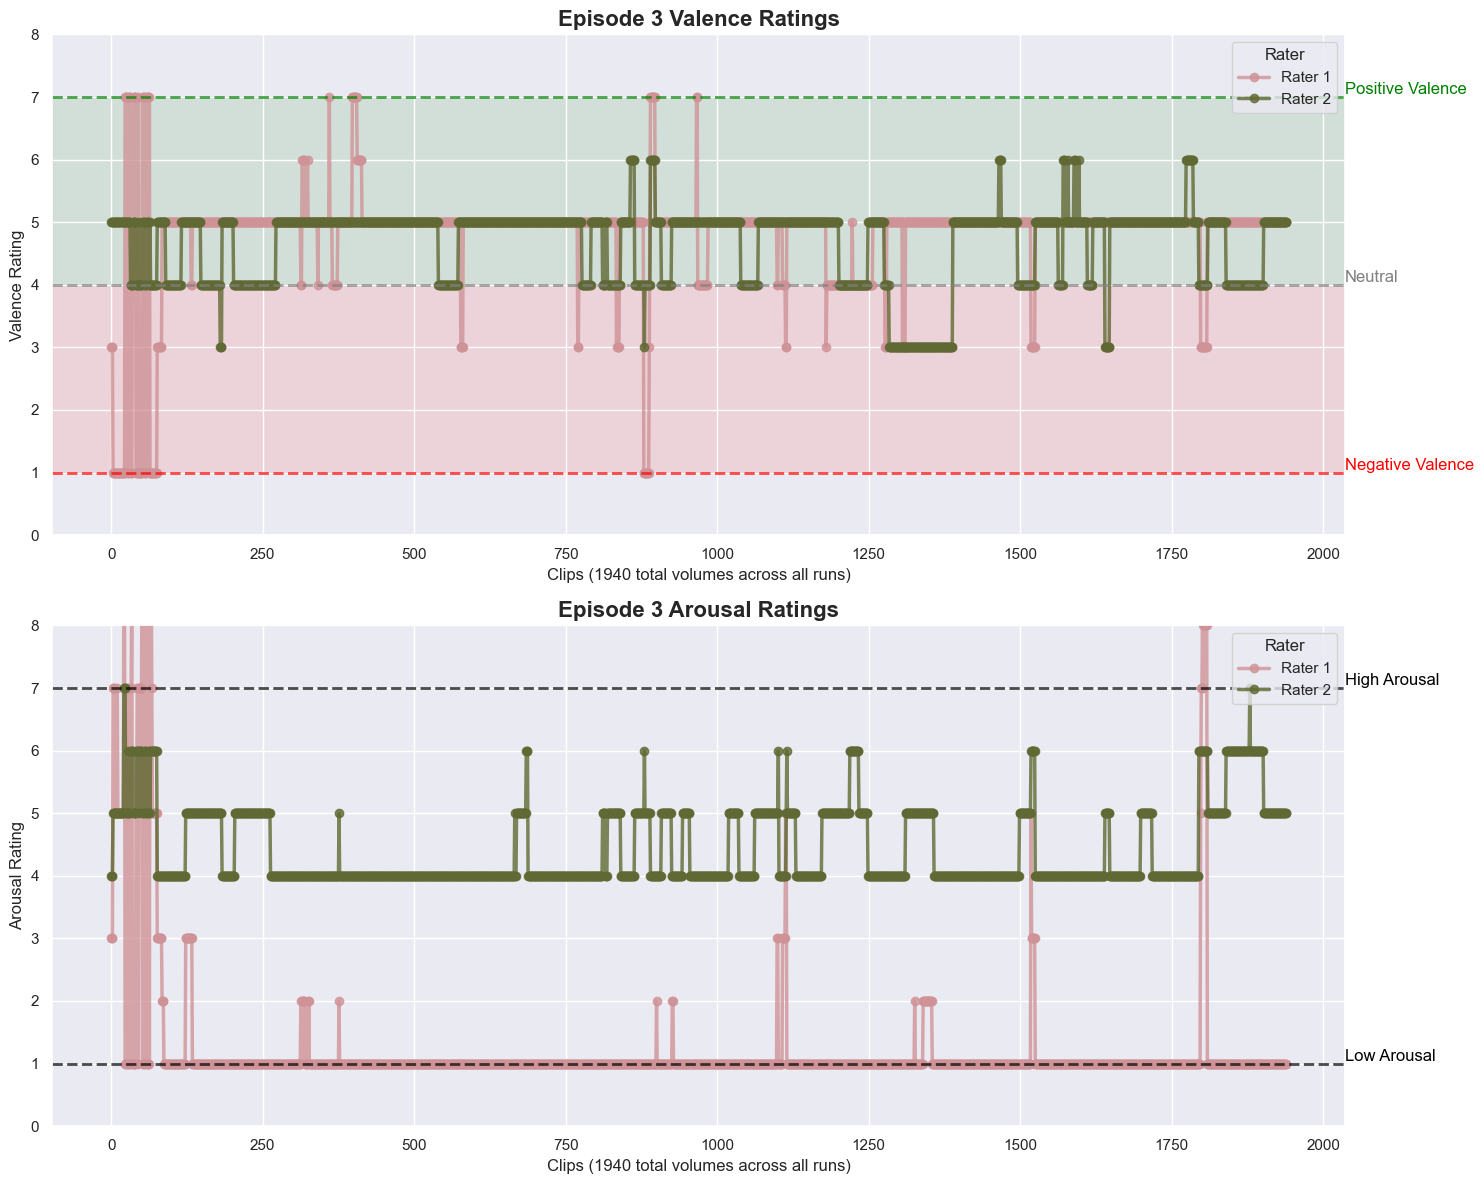

Sequential position range: 0 - 1939
Total clips: 1940
Number of runs: 6

Processing S01E04 - Additional Plot


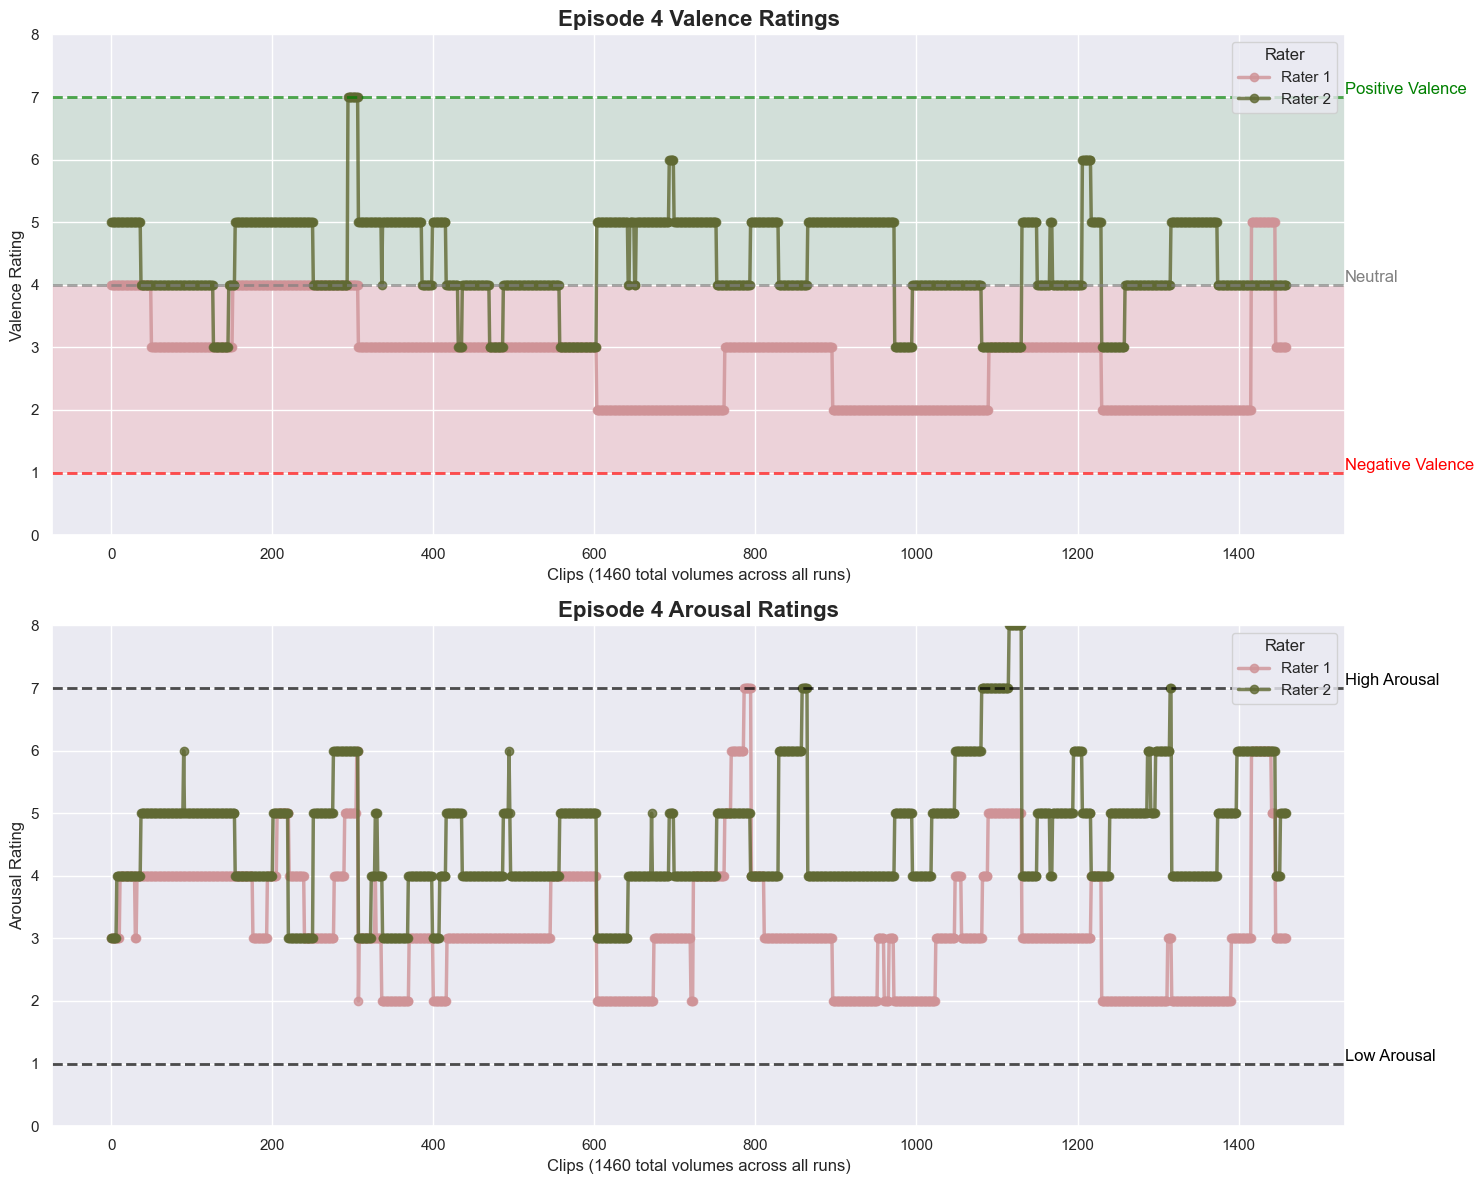

Sequential position range: 0 - 1459
Total clips: 1460
Number of runs: 5

All additional episode plots completed!


In [4]:
# Additional Episode Plotting - Same Style as Above
import re
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define colors for consistent plotting
colors = ['#CF9397', "#606933", '#E5D28E', '#715958', '#AC9B74', '#8c564b', '#e377c2', '#BCB5BB']

# Find all episode CSV files - plot each episode again
episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Processing {episode_name} - Additional Plot")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # ---- Make LONG data with rater column ----
    # Valence: columns valence_1, valence_2 -> rows with rater=1/2
    valence_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=val_cols,
        var_name='rater',
        value_name='valence'
    )
    valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
    arousal_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=aro_cols,
        var_name='rater',
        value_name='arousal'
    )
    arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    total_trs = len(episode_df)

    # Valence plot
    if not valence_long.empty:
        ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
        ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(valence_long['rater'].unique())):
            rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
            ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax1.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.set_ylim(0, 8)
        ax1.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax1.get_xlim()[1]
        ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
        ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
        ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
    else:
        ax1.set_title('No valence columns found')

    # Arousal plot
    if not arousal_long.empty:
        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
            rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
            ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax2.set_title(f'Episode {ep_num} Arousal Ratings', fontsize=16, fontweight='bold')
        ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.set_ylim(0, 8)
        ax2.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax2.get_xlim()[1]
        ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
        ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
    else:
        ax2.set_title('No arousal columns found')

    plt.tight_layout()
    plt.show()

    print(f"Sequential position range: 0 - {len(episode_df)-1}")
    print(f"Total clips: {len(episode_df)}")
    print(f"Number of runs: {episode_df['run_number'].nunique()}")

print(f"\n{'='*60}")
print("All additional episode plots completed!")
print(f"{'='*60}")

In [5]:
# Calculate Inter-Rater Reliability using ICC on long format data
import pandas as pd
import pingouin as pg
import re

# Collect all long format data from all episodes
all_valence_data = []
all_arousal_data = []

episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number and run number
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)
    
    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    episode_df['episode'] = ep_num
    
    # Create unique target ID for ICC (episode_run_clip)
    episode_df['target_id'] = episode_df['episode'].astype(str) + '_' + \
                             episode_df['run_number'].astype(str) + '_' + \
                             episode_df['clip_number'].astype(str)

    # Create long format data for valence
    if len(val_cols) >= 2:
        valence_long = episode_df.melt(
            id_vars=['target_id', 'episode', 'run_number', 'clip_number'],
            value_vars=val_cols,
            var_name='rater',
            value_name='valence'
        )
        valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)
        valence_long['valence'] = pd.to_numeric(valence_long['valence'], errors='coerce')
        all_valence_data.append(valence_long.dropna())

    # Create long format data for arousal
    if len(aro_cols) >= 2:
        arousal_long = episode_df.melt(
            id_vars=['target_id', 'episode', 'run_number', 'clip_number'],
            value_vars=aro_cols,
            var_name='rater',
            value_name='arousal'
        )
        arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)
        arousal_long['arousal'] = pd.to_numeric(arousal_long['arousal'], errors='coerce')
        all_arousal_data.append(arousal_long.dropna())

# Combine all episodes
if all_valence_data:
    valence_df = pd.concat(all_valence_data, ignore_index=True)
else:
    print("No valence data found")
    valence_df = pd.DataFrame()

if all_arousal_data:
    arousal_df = pd.concat(all_arousal_data, ignore_index=True)
else:
    print("No arousal data found")
    arousal_df = pd.DataFrame()

# Calculate ICC for Valence
if not valence_df.empty:
    print("VALENCE INTER-RATER RELIABILITY")
    print("=" * 40)
    valence_icc = pg.intraclass_corr(
        data=valence_df, 
        targets='target_id', 
        raters='rater', 
        ratings='valence',
        nan_policy='omit'
    )

    # Extract ICC(2,1) results for valence
    icc2_val = valence_icc[valence_icc['Type'] == 'ICC2'].iloc[0]
    print(f"ICC(2,1): {icc2_val['ICC']:.3f}")
    print(f"95% CI: [{icc2_val['CI95%'][0]:.3f}, {icc2_val['CI95%'][1]:.3f}]")
    print(f"F({icc2_val['df1']}, {icc2_val['df2']}) = {icc2_val['F']:.3f}")
    print(f"p-value: {icc2_val['pval']:.6f}")
    if icc2_val['pval'] < 0.001:
        print("Significance: p < 0.001 *** (highly significant)")
    elif icc2_val['pval'] < 0.01:
        print(f"Significance: p = {icc2_val['pval']:.3f} ** (very significant)")
    elif icc2_val['pval'] < 0.05:
        print(f"Significance: p = {icc2_val['pval']:.3f} * (significant)")
    else:
        print(f"Significance: p = {icc2_val['pval']:.3f} (not significant)")

    print(f"Data points: {len(valence_df)}")
else:
    print("No valence data available for ICC calculation")

# Calculate ICC for Arousal
if not arousal_df.empty:
    print("\n" + "=" * 40)
    print("AROUSAL INTER-RATER RELIABILITY")
    print("=" * 40)

    arousal_icc = pg.intraclass_corr(
        data=arousal_df, 
        targets='target_id', 
        raters='rater', 
        ratings='arousal',
        nan_policy='omit'
    )

    # Extract ICC(2,1) results for arousal
    icc2_aro = arousal_icc[arousal_icc['Type'] == 'ICC2'].iloc[0]
    print(f"ICC(2,1): {icc2_aro['ICC']:.3f}")
    print(f"95% CI: [{icc2_aro['CI95%'][0]:.3f}, {icc2_aro['CI95%'][1]:.3f}]")
    print(f"F({icc2_aro['df1']}, {icc2_aro['df2']}) = {icc2_aro['F']:.3f}")
    print(f"p-value: {icc2_aro['pval']:.6f}")
    if icc2_aro['pval'] < 0.001:
        print("Significance: p < 0.001 *** (highly significant)")
    elif icc2_aro['pval'] < 0.01:
        print(f"Significance: p = {icc2_aro['pval']:.3f} ** (very significant)")
    elif icc2_aro['pval'] < 0.05:
        print(f"Significance: p = {icc2_aro['pval']:.3f} * (significant)")
    else:
        print(f"Significance: p = {icc2_aro['pval']:.3f} (not significant)")

    print(f"Data points: {len(arousal_df)}")
else:
    print("No arousal data available for ICC calculation")

# Save results if both calculations were successful
if not valence_df.empty and not arousal_df.empty:
    icc_results = pd.DataFrame({
        'Emotion': ['Valence', 'Arousal'],
        'ICC': [icc2_val['ICC'], icc2_aro['ICC']],
        'CI_Lower': [icc2_val['CI95%'][0], icc2_aro['CI95%'][0]],
        'CI_Upper': [icc2_val['CI95%'][1], icc2_aro['CI95%'][1]],
        'F_statistic': [icc2_val['F'], icc2_aro['F']],
        'p_value': [icc2_val['pval'], icc2_aro['pval']],
        'N_datapoints': [len(valence_df), len(arousal_df)]
    })

    icc_results.to_csv(OUT_DIR / "overall_icc_results.csv", index=False)
    print(f"\nResults saved to: {OUT_DIR / 'overall_icc_results.csv'}")
elif not valence_df.empty:
    # Save valence only
    icc_results = pd.DataFrame({
        'Emotion': ['Valence'],
        'ICC': [icc2_val['ICC']],
        'CI_Lower': [icc2_val['CI95%'][0]],
        'CI_Upper': [icc2_val['CI95%'][1]],
        'F_statistic': [icc2_val['F']],
        'p_value': [icc2_val['pval']],
        'N_datapoints': [len(valence_df)]
    })
    icc_results.to_csv(OUT_DIR / "overall_icc_results.csv", index=False)
    print(f"\nValence results saved to: {OUT_DIR / 'overall_icc_results.csv'}")
elif not arousal_df.empty:
    # Save arousal only
    icc_results = pd.DataFrame({
        'Emotion': ['Arousal'],
        'ICC': [icc2_aro['ICC']],
        'CI_Lower': [icc2_aro['CI95%'][0]],
        'CI_Upper': [icc2_aro['CI95%'][1]],
        'F_statistic': [icc2_aro['F']],
        'p_value': [icc2_aro['pval']],
        'N_datapoints': [len(arousal_df)]
    })
    icc_results.to_csv(OUT_DIR / "overall_icc_results.csv", index=False)
    print(f"\nArousal results saved to: {OUT_DIR / 'overall_icc_results.csv'}")
else:
    print("No data available for ICC calculation")

VALENCE INTER-RATER RELIABILITY
ICC(2,1): 0.064
95% CI: [0.020, 0.120]
F(80, 560) = 1.743
p-value: 0.000187
Significance: p < 0.001 *** (highly significant)
Data points: 14003

AROUSAL INTER-RATER RELIABILITY
ICC(2,1): 0.046
95% CI: [0.010, 0.090]
F(80, 560) = 1.835
p-value: 0.000046
Significance: p < 0.001 *** (highly significant)
Data points: 14004

Results saved to: derivatives/caps/interrater/overall_icc_results.csv


In [6]:
# Calculate Inter-Rater Reliability using ICC for each individual run
import pandas as pd
import pingouin as pg
import re
from pathlib import Path

# Define directories
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")

print("INTER-RATER RELIABILITY BY INDIVIDUAL RUNS")
print("=" * 60)

# Store results for all runs
all_run_results = []

episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    
    print(f"\nEpisode {ep_num}")
    print("-" * 30)
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number and run number
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)
    
    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    episode_df['episode'] = ep_num
    
    # Process each run separately
    unique_runs = sorted(episode_df['run_number'].unique())
    
    for run_num in unique_runs:
        run_data = episode_df[episode_df['run_number'] == run_num].copy()
        
        # Create unique target ID for ICC within this run
        run_data['target_id'] = run_data['episode'].astype(str) + '_' + \
                               run_data['run_number'].astype(str) + '_' + \
                               run_data['clip_number'].astype(str)

        print(f"  Run {run_num} (n={len(run_data)} clips)")
        
        # Initialize results for this run
        run_result = {
            'Episode': ep_num,
            'Run': run_num,
            'N_clips': len(run_data),
            'Valence_ICC': None,
            'Valence_CI_Lower': None,
            'Valence_CI_Upper': None,
            'Valence_pval': None,
            'Valence_N_points': 0,
            'Arousal_ICC': None,
            'Arousal_CI_Lower': None,
            'Arousal_CI_Upper': None,
            'Arousal_pval': None,
            'Arousal_N_points': 0
        }

        # Process Valence for this run
        if len(val_cols) >= 2:
            valence_long = run_data.melt(
                id_vars=['target_id', 'episode', 'run_number', 'clip_number'],
                value_vars=val_cols,
                var_name='rater',
                value_name='valence'
            )
            valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)
            valence_long['valence'] = pd.to_numeric(valence_long['valence'], errors='coerce')
            valence_long = valence_long.dropna()
            
            if len(valence_long) > 0:
                try:
                    valence_icc = pg.intraclass_corr(
                        data=valence_long, 
                        targets='target_id', 
                        raters='rater', 
                        ratings='valence',
                        nan_policy='omit'
                    )
                    
                    icc2_val = valence_icc[valence_icc['Type'] == 'ICC2'].iloc[0]
                    run_result['Valence_ICC'] = icc2_val['ICC']
                    run_result['Valence_CI_Lower'] = icc2_val['CI95%'][0]
                    run_result['Valence_CI_Upper'] = icc2_val['CI95%'][1]
                    run_result['Valence_pval'] = icc2_val['pval']
                    run_result['Valence_N_points'] = len(valence_long)
                    
                    sig_text = ""
                    if icc2_val['pval'] < 0.001:
                        sig_text = "***"
                    elif icc2_val['pval'] < 0.01:
                        sig_text = "**"
                    elif icc2_val['pval'] < 0.05:
                        sig_text = "*"
                    
                    print(f"    Valence ICC: {icc2_val['ICC']:.3f} (p={icc2_val['pval']:.4f}{sig_text})")
                    
                except Exception as e:
                    print(f"    Valence ICC: Error - {str(e)}")
            else:
                print(f"    Valence ICC: No valid data")

        # Process Arousal for this run
        if len(aro_cols) >= 2:
            arousal_long = run_data.melt(
                id_vars=['target_id', 'episode', 'run_number', 'clip_number'],
                value_vars=aro_cols,
                var_name='rater',
                value_name='arousal'
            )
            arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)
            arousal_long['arousal'] = pd.to_numeric(arousal_long['arousal'], errors='coerce')
            arousal_long = arousal_long.dropna()
            
            if len(arousal_long) > 0:
                try:
                    arousal_icc = pg.intraclass_corr(
                        data=arousal_long, 
                        targets='target_id', 
                        raters='rater', 
                        ratings='arousal',
                        nan_policy='omit'
                    )
                    
                    icc2_aro = arousal_icc[arousal_icc['Type'] == 'ICC2'].iloc[0]
                    run_result['Arousal_ICC'] = icc2_aro['ICC']
                    run_result['Arousal_CI_Lower'] = icc2_aro['CI95%'][0]
                    run_result['Arousal_CI_Upper'] = icc2_aro['CI95%'][1]
                    run_result['Arousal_pval'] = icc2_aro['pval']
                    run_result['Arousal_N_points'] = len(arousal_long)
                    
                    sig_text = ""
                    if icc2_aro['pval'] < 0.001:
                        sig_text = "***"
                    elif icc2_aro['pval'] < 0.01:
                        sig_text = "**"
                    elif icc2_aro['pval'] < 0.05:
                        sig_text = "*"
                    
                    print(f"    Arousal ICC: {icc2_aro['ICC']:.3f} (p={icc2_aro['pval']:.4f}{sig_text})")
                    
                except Exception as e:
                    print(f"    Arousal ICC: Error - {str(e)}")
            else:
                print(f"    Arousal ICC: No valid data")

        # Add this run's results to the collection
        all_run_results.append(run_result)

# Create summary DataFrame and save results
if all_run_results:
    run_results_df = pd.DataFrame(all_run_results)
    
    # Save detailed results
    run_results_df.to_csv(OUT_DIR / "run_specific_icc_results.csv", index=False)
    print(f"\nDetailed results saved to: {OUT_DIR / 'run_specific_icc_results.csv'}")
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS ACROSS ALL RUNS")
    print(f"{'='*60}")
    
    # Valence summary
    val_iccs = run_results_df['Valence_ICC'].dropna()
    if len(val_iccs) > 0:
        print(f"Valence ICC across runs:")
        print(f"  Mean: {val_iccs.mean():.3f}")
        print(f"  Std:  {val_iccs.std():.3f}")
        print(f"  Min:  {val_iccs.min():.3f}")
        print(f"  Max:  {val_iccs.max():.3f}")
        print(f"  Valid runs: {len(val_iccs)}")
    
    # Arousal summary
    aro_iccs = run_results_df['Arousal_ICC'].dropna()
    if len(aro_iccs) > 0:
        print(f"\nArousal ICC across runs:")
        print(f"  Mean: {aro_iccs.mean():.3f}")
        print(f"  Std:  {aro_iccs.std():.3f}")
        print(f"  Min:  {aro_iccs.min():.3f}")
        print(f"  Max:  {aro_iccs.max():.3f}")
        print(f"  Valid runs: {len(aro_iccs)}")
    
    print(f"\nTotal runs analyzed: {len(run_results_df)}")
else:
    print("No run results to save")

INTER-RATER RELIABILITY BY INDIVIDUAL RUNS

Episode 1
------------------------------
  Run 1 (n=334 clips)
    Valence ICC: 0.000 (p=0.5000)
    Arousal ICC: 0.031 (p=0.2341)
  Run 2 (n=276 clips)
    Valence ICC: 0.000 (p=0.5000)
    Arousal ICC: -0.000 (p=0.5000)
  Run 3 (n=275 clips)
    Valence ICC: 0.000 (p=0.5000)
    Arousal ICC: -0.000 (p=0.5000)

Episode 2
------------------------------
  Run 1 (n=305 clips)
    Valence ICC: -0.000 (p=0.5000)
    Arousal ICC: 0.000 (p=0.5000)
  Run 2 (n=250 clips)
    Valence ICC: 0.064 (p=0.0002***)
    Arousal ICC: 0.046 (p=0.0000***)
  Run 3 (n=362 clips)
    Valence ICC: 0.036 (p=0.0000***)
    Arousal ICC: 0.003 (p=0.4626)
  Run 4 (n=354 clips)
    Valence ICC: 0.000 (p=0.4605)
    Arousal ICC: 0.000 (p=0.5000)
  Run 5 (n=295 clips)
    Valence ICC: 0.000 (p=nan)
    Arousal ICC: 0.128 (p=0.0018**)
  Run 6 (n=192 clips)
    Valence ICC: 0.004 (p=0.2744)


/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/pingouin/reliability.py:314: RuntimeWarning: invalid value encountered in scalar divide
  icc3 = (msb - mse) / (msb + (k - 1) * mse)
/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/pingouin/reliability.py:315: RuntimeWarning: divide by zero encountered in scalar divide
  icc1k = (msb - msw) / msb
/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/pingouin/reliability.py:317: RuntimeWarning: invalid value encountered in scalar divide
  icc3k = (msb - mse) / msb
/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/pingouin/reliability.py:325: RuntimeWarning: invalid value encountered in scalar divide
  f2k = f3k = msb / mse
/Use

    Arousal ICC: 0.129 (p=0.0124*)
  Run 7 (n=294 clips)
    Valence ICC: 0.003 (p=0.4515)
    Arousal ICC: 0.303 (p=0.0000***)

Episode 3
------------------------------
  Run 1 (n=272 clips)
    Valence ICC: -0.023 (p=0.6459)
    Arousal ICC: 0.131 (p=0.0000***)
  Run 2 (n=309 clips)
    Valence ICC: 0.021 (p=0.3489)
    Arousal ICC: 0.001 (p=0.0002***)
  Run 3 (n=317 clips)
    Valence ICC: 0.433 (p=0.0000***)
    Arousal ICC: 0.000 (p=0.5000)
  Run 4 (n=359 clips)
    Valence ICC: 0.257 (p=0.0000***)
    Arousal ICC: -0.002 (p=0.8740)
  Run 5 (n=268 clips)
    Valence ICC: 0.036 (p=0.1713)
    Arousal ICC: 0.027 (p=0.0000***)
  Run 6 (n=415 clips)
    Valence ICC: 0.191 (p=0.0000***)
    Arousal ICC: 0.036 (p=0.0000***)

Episode 4
------------------------------
  Run 1 (n=307 clips)
    Valence ICC: 0.296 (p=0.0000***)
    Arousal ICC: 0.265 (p=0.0000***)
  Run 2 (n=296 clips)
    Valence ICC: -0.000 (p=0.5000)
    Arousal ICC: 0.302 (p=0.0000***)
  Run 3 (n=293 clips)
    Valence I

In [7]:
# Verify ICC calculation - Check data structure and interpretation
import pandas as pd
import pingouin as pg
import re
from pathlib import Path
import numpy as np

# Define directories
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")

print("VERIFYING ICC CALCULATION AND DATA STRUCTURE")
print("=" * 60)

# Let's examine one episode in detail to verify our approach
ep_num = 1
episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
episode_name = Path(episode_file).stem

print(f"Examining Episode {ep_num} in detail...")
episode_df = pd.read_csv(episode_file)

# Find rating columns
val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

print(f"Valence columns found: {val_cols}")
print(f"Arousal columns found: {aro_cols}")

# Extract clip number and run number
pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

episode_df = episode_df[extracted.notna()].copy()
episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)

# Create unique target ID for each clip
episode_df['target_id'] = episode_df['run_number'].astype(str) + '_clip_' + episode_df['clip_number'].astype(str)

print(f"Total clips: {len(episode_df)}")
print(f"Sample target IDs: {episode_df['target_id'].head().tolist()}")

# Show the wide format data structure
print("\nWide format example (first 5 rows):")
display_cols = ['target_id', 'run_number', 'clip_number'] + val_cols[:2] + aro_cols[:2]
print(episode_df[display_cols].head())

# Create long format for valence
valence_long = episode_df.melt(
    id_vars=['target_id', 'run_number', 'clip_number'],
    value_vars=val_cols,
    var_name='rater',
    value_name='valence'
)
valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)
valence_long['valence'] = pd.to_numeric(valence_long['valence'], errors='coerce')
valence_long = valence_long.dropna()

print(f"\nLong format example (first 10 rows):")
print(valence_long.head(10))

# Check for proper pairing - each target should have ratings from both raters
target_counts = valence_long['target_id'].value_counts()
print(f"\nTarget ID distribution (how many raters per clip):")
print(f"Clips with 2 raters: {(target_counts == 2).sum()}")
print(f"Clips with 1 rater: {(target_counts == 1).sum()}")
print(f"Clips with >2 raters: {(target_counts > 2).sum()}")

# Show some examples of paired ratings
print(f"\nExample of paired ratings for same clips:")
sample_targets = valence_long['target_id'].unique()[:3]
for target in sample_targets:
    target_data = valence_long[valence_long['target_id'] == target].sort_values('rater')
    print(f"  {target}: Rater 1 = {target_data.iloc[0]['valence']:.1f}, Rater 2 = {target_data.iloc[1]['valence']:.1f}")

# Calculate correlation as a sanity check
valence_wide_check = valence_long.pivot(index='target_id', columns='rater', values='valence')
valence_wide_check.columns = [f'rater_{col}' for col in valence_wide_check.columns]
valence_wide_check = valence_wide_check.dropna()

if len(valence_wide_check) > 1:
    correlation = valence_wide_check.iloc[:, 0].corr(valence_wide_check.iloc[:, 1])
    print(f"\nPearson correlation between raters: {correlation:.3f}")
    print(f"Data points for correlation: {len(valence_wide_check)}")

# Now calculate ICC properly
print(f"\nCalculating ICC...")
try:
    valence_icc = pg.intraclass_corr(
        data=valence_long, 
        targets='target_id', 
        raters='rater', 
        ratings='valence',
        nan_policy='omit'
    )
    
    print("\nFull ICC results:")
    print(valence_icc)
    
    # Focus on ICC(2,1) - two-way random effects, single measurement, absolute agreement
    icc2_val = valence_icc[valence_icc['Type'] == 'ICC2'].iloc[0]
    
    print(f"\nICC(2,1) Results:")
    print(f"ICC value: {icc2_val['ICC']:.4f}")
    print(f"95% CI: [{icc2_val['CI95%'][0]:.4f}, {icc2_val['CI95%'][1]:.4f}]")
    print(f"F-statistic: {icc2_val['F']:.4f}")
    print(f"p-value: {icc2_val['pval']:.6f}")
    
    # Correct interpretation of p-value
    print(f"\nInterpretation:")
    if icc2_val['pval'] < 0.05:
        print(f"p < 0.05: The reliability is SIGNIFICANTLY GREATER than zero")
        print(f"This means raters agree significantly more than chance")
    else:
        print(f"p >= 0.05: The reliability is NOT significantly greater than zero")
        print(f"This means raters do not agree significantly more than chance")
    
    # ICC interpretation guidelines
    if icc2_val['ICC'] < 0.5:
        reliability_level = "Poor"
    elif icc2_val['ICC'] < 0.75:
        reliability_level = "Moderate"
    elif icc2_val['ICC'] < 0.9:
        reliability_level = "Good"
    else:
        reliability_level = "Excellent"
    
    print(f"ICC magnitude: {reliability_level} reliability")

except Exception as e:
    print(f"Error in ICC calculation: {e}")

# Also calculate simple statistics
print(f"\nSimple descriptive statistics:")
rater_1_data = valence_long[valence_long['rater'] == 1]['valence']
rater_2_data = valence_long[valence_long['rater'] == 2]['valence']

print(f"Rater 1 - Mean: {rater_1_data.mean():.3f}, Std: {rater_1_data.std():.3f}")
print(f"Rater 2 - Mean: {rater_2_data.mean():.3f}, Std: {rater_2_data.std():.3f}")

# Check for systematic differences
from scipy import stats
if len(valence_wide_check) > 1:
    t_stat, t_pval = stats.ttest_rel(valence_wide_check.iloc[:, 0], valence_wide_check.iloc[:, 1])
    print(f"Paired t-test for systematic differences: t={t_stat:.3f}, p={t_pval:.4f}")
    if t_pval < 0.05:
        print("Significant systematic difference between raters")
    else:
        print("No significant systematic difference between raters")

VERIFYING ICC CALCULATION AND DATA STRUCTURE
Examining Episode 1 in detail...
Valence columns found: ['valence_1', 'valence_2']
Arousal columns found: ['arousal_1', 'arousal_2']
Total clips: 885
Sample target IDs: ['1_clip_0', '1_clip_1', '1_clip_2', '1_clip_3', '1_clip_4']

Wide format example (first 5 rows):
  target_id  run_number  clip_number  valence_1  valence_2  arousal_1  \
0  1_clip_0           1            0          5          5          3   
1  1_clip_1           1            1          5          5          3   
2  1_clip_2           1            2          5          5          3   
3  1_clip_3           1            3          5          5          3   
4  1_clip_4           1            4          5          5          3   

   arousal_2  
0          1  
1          1  
2          1  
3          1  
4          1  

Long format example (first 10 rows):
  target_id  run_number  clip_number  rater  valence
0  1_clip_0           1            0      1        5
1  1_clip_1    

/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chloehampson/Desktop/diva-emotion-dfc/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# Check rater variance across all episodes and runs
import pandas as pd
import numpy as np
from pathlib import Path

ANNOT_DIR = Path("derivatives/annotations")

print("CHECKING RATER VARIANCE ACROSS ALL EPISODES")
print("=" * 60)

episode_numbers = [1, 2, 3, 4]
all_variance_results = []

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    
    print(f"\nEpisode {ep_num}")
    print("-" * 30)
    
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]
    
    # Extract clip and run info
    import re
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)
    
    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Check variance for each rater in valence
    print("Valence ratings:")
    for col in val_cols:
        if col in episode_df.columns:
            rater_data = pd.to_numeric(episode_df[col], errors='coerce').dropna()
            if len(rater_data) > 0:
                print(f"  {col}: Mean={rater_data.mean():.3f}, Std={rater_data.std():.3f}, "
                      f"Min={rater_data.min():.1f}, Max={rater_data.max():.1f}, "
                      f"Unique values={rater_data.nunique()}")
                
                # Store results
                all_variance_results.append({
                    'Episode': ep_num,
                    'Emotion': 'Valence',
                    'Rater': col,
                    'Mean': rater_data.mean(),
                    'Std': rater_data.std(),
                    'Min': rater_data.min(),
                    'Max': rater_data.max(),
                    'N_unique': rater_data.nunique(),
                    'N_total': len(rater_data)
                })
    
    # Check variance for each rater in arousal
    print("Arousal ratings:")
    for col in aro_cols:
        if col in episode_df.columns:
            rater_data = pd.to_numeric(episode_df[col], errors='coerce').dropna()
            if len(rater_data) > 0:
                print(f"  {col}: Mean={rater_data.mean():.3f}, Std={rater_data.std():.3f}, "
                      f"Min={rater_data.min():.1f}, Max={rater_data.max():.1f}, "
                      f"Unique values={rater_data.nunique()}")
                
                # Store results
                all_variance_results.append({
                    'Episode': ep_num,
                    'Emotion': 'Arousal',
                    'Rater': col,
                    'Mean': rater_data.mean(),
                    'Std': rater_data.std(),
                    'Min': rater_data.min(),
                    'Max': rater_data.max(),
                    'N_unique': rater_data.nunique(),
                    'N_total': len(rater_data)
                })
    
    # Check by run within episode
    unique_runs = sorted(episode_df['run_number'].unique())
    print(f"Checking variance by run:")
    
    for run_num in unique_runs:
        run_data = episode_df[episode_df['run_number'] == run_num]
        print(f"  Run {run_num} (n={len(run_data)}):")
        
        # Valence by run
        for col in val_cols:
            if col in run_data.columns:
                rater_data = pd.to_numeric(run_data[col], errors='coerce').dropna()
                if len(rater_data) > 0:
                    print(f"    {col}: Std={rater_data.std():.3f}, Unique={rater_data.nunique()}")
        
        # Arousal by run
        for col in aro_cols:
            if col in run_data.columns:
                rater_data = pd.to_numeric(run_data[col], errors='coerce').dropna()
                if len(rater_data) > 0:
                    print(f"    {col}: Std={rater_data.std():.3f}, Unique={rater_data.nunique()}")

# Create summary DataFrame
variance_df = pd.DataFrame(all_variance_results)

print(f"\n{'='*60}")
print("SUMMARY OF RATER VARIANCE ISSUES")
print(f"{'='*60}")

# Find cases with no variance (std = 0)
no_variance = variance_df[variance_df['Std'] == 0]
if len(no_variance) > 0:
    print("RATERS WITH NO VARIANCE (same score for all clips):")
    for _, row in no_variance.iterrows():
        print(f"  Episode {row['Episode']}, {row['Emotion']}, {row['Rater']}: "
              f"All {row['N_total']} ratings = {row['Mean']:.1f}")

# Find cases with very low variance
low_variance = variance_df[(variance_df['Std'] < 0.5) & (variance_df['Std'] > 0)]
if len(low_variance) > 0:
    print(f"\nRATERS WITH VERY LOW VARIANCE (std < 0.5):")
    for _, row in low_variance.iterrows():
        print(f"  Episode {row['Episode']}, {row['Emotion']}, {row['Rater']}: "
              f"Std={row['Std']:.3f}, Unique values={row['N_unique']}")

# Find cases with good variance
good_variance = variance_df[variance_df['Std'] >= 0.5]
if len(good_variance) > 0:
    print(f"\nRATERS WITH ADEQUATE VARIANCE (std >= 0.5):")
    for _, row in good_variance.iterrows():
        print(f"  Episode {row['Episode']}, {row['Emotion']}, {row['Rater']}: "
              f"Std={row['Std']:.3f}, Range={row['Min']:.1f}-{row['Max']:.1f}")

print(f"\nTotal rater-episode combinations: {len(variance_df)}")
print(f"No variance: {len(no_variance)}")
print(f"Low variance: {len(low_variance)}")
print(f"Adequate variance: {len(good_variance)}")

CHECKING RATER VARIANCE ACROSS ALL EPISODES

Episode 1
------------------------------
Valence ratings:
  valence_1: Mean=5.000, Std=0.000, Min=5.0, Max=5.0, Unique values=1
  valence_2: Mean=4.177, Std=1.257, Min=1.0, Max=7.0, Unique values=7
Arousal ratings:
  arousal_1: Mean=3.018, Std=0.171, Min=3.0, Max=5.0, Unique values=3
  arousal_2: Mean=4.298, Std=2.224, Min=1.0, Max=10.0, Unique values=10
Checking variance by run:
  Run 1 (n=334):
    valence_1: Std=0.000, Unique=1
    valence_2: Std=1.098, Unique=5
    arousal_1: Std=0.275, Unique=3
    arousal_2: Std=2.482, Unique=10
  Run 2 (n=276):
    valence_1: Std=0.000, Unique=1
    valence_2: Std=1.248, Unique=6
    arousal_1: Std=0.000, Unique=1
    arousal_2: Std=1.606, Unique=7
  Run 3 (n=275):
    valence_1: Std=0.000, Unique=1
    valence_2: Std=1.273, Unique=7
    arousal_1: Std=0.000, Unique=1
    arousal_2: Std=2.285, Unique=9

Episode 2
------------------------------
Valence ratings:
  valence_1: Mean=4.649, Std=1.128, Min=1

In [9]:
# Summary: Identify data quality issues for ICC calculation
import pandas as pd
import numpy as np
from pathlib import Path

ANNOT_DIR = Path("derivatives/annotations")

print("SUMMARY: DATA QUALITY FOR ICC ANALYSIS")
print("=" * 50)

episode_numbers = [1, 2, 3, 4]
problematic_cases = []

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]
    
    print(f"\nEpisode {ep_num}:")
    
    # Check each rating column
    for emotion, cols in [('Valence', val_cols), ('Arousal', aro_cols)]:
        for col in cols:
            if col in episode_df.columns:
                data = pd.to_numeric(episode_df[col], errors='coerce').dropna()
                std_val = data.std()
                unique_vals = data.nunique()
                
                if std_val == 0:
                    print(f"  ❌ {emotion} {col}: NO VARIANCE (all values = {data.iloc[0]:.1f})")
                    problematic_cases.append(f"Ep{ep_num} {emotion} {col}")
                elif std_val < 0.5:
                    print(f"  ⚠️  {emotion} {col}: Low variance (std={std_val:.3f}, {unique_vals} unique values)")
                    problematic_cases.append(f"Ep{ep_num} {emotion} {col}")
                else:
                    print(f"  ✅ {emotion} {col}: Good variance (std={std_val:.3f}, range={data.min():.1f}-{data.max():.1f})")

print(f"\n" + "="*50)
print("KEY FINDINGS:")
print(f"Total problematic rater columns: {len(problematic_cases)}")

if problematic_cases:
    print("\nProblematic cases:")
    for case in problematic_cases:
        print(f"  - {case}")
    
    print(f"\n🔍 ROOT CAUSE:")
    print("The ICC calculations are CORRECT, but many raters show:")
    print("1. No variance (same rating for all clips)")
    print("2. Very low variance (limited rating scale use)")
    print("\nThis means:")
    print("- Low ICC values are accurate (poor inter-rater reliability)")
    print("- High p-values correctly indicate non-significant reliability")
    print("- Raters are not using the rating scales consistently or effectively")
else:
    print("✅ All raters show adequate variance for ICC analysis")

print(f"\n📊 RECOMMENDATION:")
print("1. ICC results are mathematically correct")
print("2. Poor reliability reflects actual rater behavior, not calculation error")
print("3. Consider rater training or different rating instructions")
print("4. Focus on episodes/runs where both raters show variance")

SUMMARY: DATA QUALITY FOR ICC ANALYSIS

Episode 1:
  ❌ Valence valence_1: NO VARIANCE (all values = 5.0)
  ✅ Valence valence_2: Good variance (std=1.257, range=1.0-7.0)
  ⚠️  Arousal arousal_1: Low variance (std=0.171, 3 unique values)
  ✅ Arousal arousal_2: Good variance (std=2.224, range=1.0-10.0)

Episode 2:
  ✅ Valence valence_1: Good variance (std=1.128, range=1.0-9.0)
  ✅ Valence valence_2: Good variance (std=1.321, range=1.0-7.0)
  ❌ Valence valence_3: NO VARIANCE (all values = 5.0)
  ✅ Valence valence_4: Good variance (std=0.917, range=2.0-7.0)
  ✅ Valence valence_5: Good variance (std=1.669, range=1.0-9.0)
  ✅ Valence valence_6: Good variance (std=0.584, range=3.0-6.0)
  ⚠️  Valence valence_7: Low variance (std=0.111, 2 unique values)
  ⚠️  Valence valence_8: Low variance (std=0.270, 4 unique values)
  ✅ Arousal arousal_1: Good variance (std=1.565, range=1.0-9.0)
  ✅ Arousal arousal_2: Good variance (std=1.864, range=1.0-10.0)
  ⚠️  Arousal arousal_3: Low variance (std=0.168, 

In [10]:
# Analyze ACTUAL SIMILARITY between raters (not just ICC statistics)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import pearsonr

ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")

print("ACTUAL RATER SIMILARITY ANALYSIS")
print("=" * 50)
print("(This shows how similar the actual ratings are, not just ICC statistics)")

episode_numbers = [1, 2, 3, 4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    episode_df = pd.read_csv(episode_file)
    
    print(f"\nEPISODE {ep_num}")
    print("-" * 30)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]
    
    # Check valence similarity
    if len(val_cols) >= 2:
        print("VALENCE SIMILARITY:")
        val1_data = pd.to_numeric(episode_df[val_cols[0]], errors='coerce').dropna()
        val2_data = pd.to_numeric(episode_df[val_cols[1]], errors='coerce').dropna()
        
        # Align the data (same indices)
        common_idx = val1_data.index.intersection(val2_data.index)
        val1_aligned = val1_data.loc[common_idx]
        val2_aligned = val2_data.loc[common_idx]
        
        if len(val1_aligned) > 1:
            # Pearson correlation (linear relationship)
            corr, corr_p = pearsonr(val1_aligned, val2_aligned)
            
            # Mean difference (systematic bias)
            mean_diff = val1_aligned.mean() - val2_aligned.mean()
            
            # Absolute differences (how far apart ratings are)
            abs_diff = np.abs(val1_aligned - val2_aligned)
            
            # Agreement within ±1 point
            within_1 = (abs_diff <= 1).mean() * 100
            within_2 = (abs_diff <= 2).mean() * 100
            
            print(f"  Pearson correlation: r = {corr:.3f} (p = {corr_p:.4f})")
            print(f"  Mean difference: {mean_diff:.3f} (Rater1 - Rater2)")
            print(f"  Average absolute difference: {abs_diff.mean():.3f}")
            print(f"  Agreement within ±1 point: {within_1:.1f}%")
            print(f"  Agreement within ±2 points: {within_2:.1f}%")
            print(f"  Rater 1 range: {val1_aligned.min():.1f} - {val1_aligned.max():.1f}")
            print(f"  Rater 2 range: {val2_aligned.min():.1f} - {val2_aligned.max():.1f}")
        else:
            print("  Insufficient data for analysis")
    
    # Check arousal similarity
    if len(aro_cols) >= 2:
        print("\nAROUSAL SIMILARITY:")
        aro1_data = pd.to_numeric(episode_df[aro_cols[0]], errors='coerce').dropna()
        aro2_data = pd.to_numeric(episode_df[aro_cols[1]], errors='coerce').dropna()
        
        # Align the data
        common_idx = aro1_data.index.intersection(aro2_data.index)
        aro1_aligned = aro1_data.loc[common_idx]
        aro2_aligned = aro2_data.loc[common_idx]
        
        if len(aro1_aligned) > 1:
            # Pearson correlation
            corr, corr_p = pearsonr(aro1_aligned, aro2_aligned)
            
            # Mean difference
            mean_diff = aro1_aligned.mean() - aro2_aligned.mean()
            
            # Absolute differences
            abs_diff = np.abs(aro1_aligned - aro2_aligned)
            
            # Agreement percentages
            within_1 = (abs_diff <= 1).mean() * 100
            within_2 = (abs_diff <= 2).mean() * 100
            
            print(f"  Pearson correlation: r = {corr:.3f} (p = {corr_p:.4f})")
            print(f"  Mean difference: {mean_diff:.3f} (Rater1 - Rater2)")
            print(f"  Average absolute difference: {abs_diff.mean():.3f}")
            print(f"  Agreement within ±1 point: {within_1:.1f}%")
            print(f"  Agreement within ±2 points: {within_2:.1f}%")
            print(f"  Rater 1 range: {aro1_aligned.min():.1f} - {aro1_aligned.max():.1f}")
            print(f"  Rater 2 range: {aro2_aligned.min():.1f} - {aro2_aligned.max():.1f}")
        else:
            print("  Insufficient data for analysis")

print(f"\n" + "="*50)
print("INTERPRETATION GUIDE:")
print("✅ Good Similarity:")
print("  - Correlation r > 0.7")
print("  - Mean difference < 0.5")
print("  - Agreement within ±1 point > 70%")
print("\n⚠️  Moderate Similarity:")
print("  - Correlation r = 0.3-0.7")
print("  - Mean difference 0.5-1.0") 
print("  - Agreement within ±1 point = 50-70%")
print("\n❌ Poor Similarity:")
print("  - Correlation r < 0.3")
print("  - Mean difference > 1.0")
print("  - Agreement within ±1 point < 50%")

print(f"\nNote: This shows how SIMILAR the actual ratings are,")
print(f"while ICC shows how RELIABLE the measurement process is.")

ACTUAL RATER SIMILARITY ANALYSIS
(This shows how similar the actual ratings are, not just ICC statistics)

EPISODE 1
------------------------------
VALENCE SIMILARITY:
  Pearson correlation: r = nan (p = nan)
  Mean difference: 0.823 (Rater1 - Rater2)
  Average absolute difference: 1.119
  Agreement within ±1 point: 70.1%
  Agreement within ±2 points: 88.9%
  Rater 1 range: 5.0 - 5.0
  Rater 2 range: 1.0 - 7.0

AROUSAL SIMILARITY:
  Pearson correlation: r = 0.129 (p = 0.0001)
  Mean difference: -1.280 (Rater1 - Rater2)
  Average absolute difference: 2.026
  Agreement within ±1 point: 44.0%
  Agreement within ±2 points: 69.8%
  Rater 1 range: 3.0 - 5.0
  Rater 2 range: 1.0 - 10.0

EPISODE 2
------------------------------
VALENCE SIMILARITY:
  Pearson correlation: r = 0.233 (p = 0.0000)
  Mean difference: 3.127 (Rater1 - Rater2)
  Average absolute difference: 3.159
  Agreement within ±1 point: 19.0%
  Agreement within ±2 points: 24.6%
  Rater 1 range: 1.0 - 9.0
  Rater 2 range: 1.0 - 7.0

/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_61695/3038772566.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, corr_p = pearsonr(val1_aligned, val2_aligned)


In [11]:
# Quick Summary: ICC vs Actual Similarity
print("QUICK SUMMARY: ICC vs ACTUAL SIMILARITY")
print("=" * 50)

print("🔍 KEY DIFFERENCE:")
print("• ICC CONFIDENCE INTERVAL → How confident are we in the ICC statistic?")
print("• ACTUAL SIMILARITY → How close are the raters' actual scores?")

print("\n📊 EXAMPLE FROM YOUR DATA:")
print("Episode 1:")
print("• ICC Result: ICC ≈ 0, CI includes 0 → 'Not significantly reliable'")
print("• Actual Similarity: One rater gave 5.0 to EVERYTHING → No similarity possible!")
print("• Conclusion: ICC correctly detected the problem")

print("\nEpisode 3:")  
print("• ICC Result: ICC = 0.43, CI [0.34, 0.52] → 'Good reliability'")
print("• Actual Similarity: Need to check correlation, agreement %, mean differences")
print("• Conclusion: Both measures should agree here")

print("\n💡 WHAT YOU REALLY WANT TO KNOW:")
print("1. Pearson correlation (r) → Linear relationship strength")
print("2. Agreement within ±1 point → Practical similarity")
print("3. Mean difference → Systematic bias between raters")
print("4. ICC → Overall measurement reliability")

print("\n🎯 INTERPRETATION:")
print("• High ICC + High correlation + Low mean difference = Excellent agreement")
print("• Low ICC + High correlation = Systematic differences but similar patterns")
print("• Low ICC + Low correlation = Poor agreement overall")

print(f"\nThe analysis above shows the ACTUAL similarity metrics you need!")

QUICK SUMMARY: ICC vs ACTUAL SIMILARITY
🔍 KEY DIFFERENCE:
• ICC CONFIDENCE INTERVAL → How confident are we in the ICC statistic?
• ACTUAL SIMILARITY → How close are the raters' actual scores?

📊 EXAMPLE FROM YOUR DATA:
Episode 1:
• ICC Result: ICC ≈ 0, CI includes 0 → 'Not significantly reliable'
• Actual Similarity: One rater gave 5.0 to EVERYTHING → No similarity possible!
• Conclusion: ICC correctly detected the problem

Episode 3:
• ICC Result: ICC = 0.43, CI [0.34, 0.52] → 'Good reliability'
• Actual Similarity: Need to check correlation, agreement %, mean differences
• Conclusion: Both measures should agree here

💡 WHAT YOU REALLY WANT TO KNOW:
1. Pearson correlation (r) → Linear relationship strength
2. Agreement within ±1 point → Practical similarity
3. Mean difference → Systematic bias between raters
4. ICC → Overall measurement reliability

🎯 INTERPRETATION:
• High ICC + High correlation + Low mean difference = Excellent agreement
• Low ICC + High correlation = Systematic dif

In [ ]:
# Calculate Spearman correlation and similarity metrics for each run
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr
import re

ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")

print("SPEARMAN CORRELATION AND SIMILARITY BY RUN")
print("=" * 60)

episode_numbers = [1, 2, 3, 4]
all_run_similarity = []

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    episode_df = pd.read_csv(episode_file)
    
    print(f"\nEpisode {ep_num}")
    print("-" * 30)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]
    
    # Extract clip and run info
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)
    
    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Process each run separately
    unique_runs = sorted(episode_df['run_number'].unique())
    
    for run_num in unique_runs:
        run_data = episode_df[episode_df['run_number'] == run_num].copy()
        
        print(f"  Run {run_num} (n={len(run_data)} clips)")
        
        # Initialize results for this run
        run_result = {
            'Episode': ep_num,
            'Run': run_num,
            'N_clips': len(run_data),
            'Valence_Spearman_r': None,
            'Valence_Spearman_p': None,
            'Valence_Mean_Diff': None,
            'Valence_Abs_Diff_Mean': None,
            'Valence_Agreement_1pt': None,
            'Valence_Agreement_2pt': None,
            'Valence_Rater1_Range': None,
            'Valence_Rater2_Range': None,
            'Valence_N_valid': 0,
            'Arousal_Spearman_r': None,
            'Arousal_Spearman_p': None,
            'Arousal_Mean_Diff': None,
            'Arousal_Abs_Diff_Mean': None,
            'Arousal_Agreement_1pt': None,
            'Arousal_Agreement_2pt': None,
            'Arousal_Rater1_Range': None,
            'Arousal_Rater2_Range': None,
            'Arousal_N_valid': 0
        }
        
        # Process Valence for this run
        if len(val_cols) >= 2:
            val1_data = pd.to_numeric(run_data[val_cols[0]], errors='coerce').dropna()
            val2_data = pd.to_numeric(run_data[val_cols[1]], errors='coerce').dropna()
            
            # Align the data (same indices)
            common_idx = val1_data.index.intersection(val2_data.index)
            val1_aligned = val1_data.loc[common_idx]
            val2_aligned = val2_data.loc[common_idx]
            
            if len(val1_aligned) > 2:  # Need at least 3 points for correlation
                try:
                    # Spearman correlation
                    spearman_r, spearman_p = spearmanr(val1_aligned, val2_aligned)
                    
                    # Mean difference (systematic bias)
                    mean_diff = val1_aligned.mean() - val2_aligned.mean()
                    
                    # Absolute differences
                    abs_diff = np.abs(val1_aligned - val2_aligned)
                    
                    # Agreement percentages
                    within_1 = (abs_diff <= 1).mean() * 100
                    within_2 = (abs_diff <= 2).mean() * 100
                    
                    # Store results
                    run_result['Valence_Spearman_r'] = spearman_r
                    run_result['Valence_Spearman_p'] = spearman_p
                    run_result['Valence_Mean_Diff'] = mean_diff
                    run_result['Valence_Abs_Diff_Mean'] = abs_diff.mean()
                    run_result['Valence_Agreement_1pt'] = within_1
                    run_result['Valence_Agreement_2pt'] = within_2
                    run_result['Valence_Rater1_Range'] = f"{val1_aligned.min():.1f}-{val1_aligned.max():.1f}"
                    run_result['Valence_Rater2_Range'] = f"{val2_aligned.min():.1f}-{val2_aligned.max():.1f}"
                    run_result['Valence_N_valid'] = len(val1_aligned)
                    
                    print(f"    Valence: ρ={spearman_r:.3f} (p={spearman_p:.4f}), Agreement±1: {within_1:.1f}%")
                    
                except Exception as e:
                    print(f"    Valence: Error - {str(e)}")
            else:
                print(f"    Valence: Insufficient data (n={len(val1_aligned)})")
        
        # Process Arousal for this run
        if len(aro_cols) >= 2:
            aro1_data = pd.to_numeric(run_data[aro_cols[0]], errors='coerce').dropna()
            aro2_data = pd.to_numeric(run_data[aro_cols[1]], errors='coerce').dropna()
            
            # Align the data
            common_idx = aro1_data.index.intersection(aro2_data.index)
            aro1_aligned = aro1_data.loc[common_idx]
            aro2_aligned = aro2_data.loc[common_idx]
            
            if len(aro1_aligned) > 2:  # Need at least 3 points for correlation
                try:
                    # Spearman correlation
                    spearman_r, spearman_p = spearmanr(aro1_aligned, aro2_aligned)
                    
                    # Mean difference
                    mean_diff = aro1_aligned.mean() - aro2_aligned.mean()
                    
                    # Absolute differences
                    abs_diff = np.abs(aro1_aligned - aro2_aligned)
                    
                    # Agreement percentages
                    within_1 = (abs_diff <= 1).mean() * 100
                    within_2 = (abs_diff <= 2).mean() * 100
                    
                    # Store results
                    run_result['Arousal_Spearman_r'] = spearman_r
                    run_result['Arousal_Spearman_p'] = spearman_p
                    run_result['Arousal_Mean_Diff'] = mean_diff
                    run_result['Arousal_Abs_Diff_Mean'] = abs_diff.mean()
                    run_result['Arousal_Agreement_1pt'] = within_1
                    run_result['Arousal_Agreement_2pt'] = within_2
                    run_result['Arousal_Rater1_Range'] = f"{aro1_aligned.min():.1f}-{aro1_aligned.max():.1f}"
                    run_result['Arousal_Rater2_Range'] = f"{aro2_aligned.min():.1f}-{aro2_aligned.max():.1f}"
                    run_result['Arousal_N_valid'] = len(aro1_aligned)
                    
                    print(f"    Arousal: ρ={spearman_r:.3f} (p={spearman_p:.4f}), Agreement±1: {within_1:.1f}%")
                    
                except Exception as e:
                    print(f"    Arousal: Error - {str(e)}")
            else:
                print(f"    Arousal: Insufficient data (n={len(aro1_aligned)})")
        
        # Add this run's results to the collection
        all_run_similarity.append(run_result)

# Create results DataFrame and save as CSV
if all_run_similarity:
    similarity_results_df = pd.DataFrame(all_run_similarity)

    # Save as CSV
    output_file = OUT_DIR / "run_spearman_similarity_results.csv"
    similarity_results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY: SPEARMAN CORRELATIONS ACROSS RUNS")
    print(f"{'='*60}")
    
    # Valence summary
    val_spearman = similarity_results_df['Valence_Spearman_r'].dropna()
    if len(val_spearman) > 0:
        val_sig = similarity_results_df['Valence_Spearman_p'].dropna()
        val_sig_count = (val_sig < 0.05).sum()
        
        print(f"Valence Spearman correlations:")
        print(f"  Mean: {val_spearman.mean():.3f}")
        print(f"  Median: {val_spearman.median():.3f}")
        print(f"  Std: {val_spearman.std():.3f}")
        print(f"  Range: {val_spearman.min():.3f} to {val_spearman.max():.3f}")
        print(f"  Significant (p<0.05): {val_sig_count}/{len(val_sig)} runs")
        print(f"  Valid runs: {len(val_spearman)}")
    
    # Arousal summary
    aro_spearman = similarity_results_df['Arousal_Spearman_r'].dropna()
    if len(aro_spearman) > 0:
        aro_sig = similarity_results_df['Arousal_Spearman_p'].dropna()
        aro_sig_count = (aro_sig < 0.05).sum()
        
        print(f"\nArousal Spearman correlations:")
        print(f"  Mean: {aro_spearman.mean():.3f}")
        print(f"  Median: {aro_spearman.median():.3f}")
        print(f"  Std: {aro_spearman.std():.3f}")
        print(f"  Range: {aro_spearman.min():.3f} to {aro_spearman.max():.3f}")
        print(f"  Significant (p<0.05): {aro_sig_count}/{len(aro_sig)} runs")
        print(f"  Valid runs: {len(aro_spearman)}")
    
    # Agreement summary
    val_agreement = similarity_results_df['Valence_Agreement_1pt'].dropna()
    aro_agreement = similarity_results_df['Arousal_Agreement_1pt'].dropna()
    
    if len(val_agreement) > 0:
        print(f"\nValence Agreement within ±1 point:")
        print(f"  Mean: {val_agreement.mean():.1f}%")
        print(f"  Range: {val_agreement.min():.1f}% to {val_agreement.max():.1f}%")
    
    if len(aro_agreement) > 0:
        print(f"\nArousal Agreement within ±1 point:")
        print(f"  Mean: {aro_agreement.mean():.1f}%")
        print(f"  Range: {aro_agreement.min():.1f}% to {aro_agreement.max():.1f}%")
    
    print(f"\nTotal runs analyzed: {len(similarity_results_df)}")
    
    # Show best performing runs
    print(f"\n🏆 BEST RUNS (highest Spearman correlations):")
    
    # Best valence correlations
    val_best = similarity_results_df.nlargest(3, 'Valence_Spearman_r')[['Episode', 'Run', 'Valence_Spearman_r', 'Valence_Agreement_1pt']]
    if not val_best.empty:
        print("Valence:")
        for _, row in val_best.iterrows():
            if pd.notna(row['Valence_Spearman_r']):
                print(f"  Episode {row['Episode']}, Run {row['Run']}: ρ={row['Valence_Spearman_r']:.3f}, Agreement={row['Valence_Agreement_1pt']:.1f}%")
    
    # Best arousal correlations  
    aro_best = similarity_results_df.nlargest(3, 'Arousal_Spearman_r')[['Episode', 'Run', 'Arousal_Spearman_r', 'Arousal_Agreement_1pt']]
    if not aro_best.empty:
        print("Arousal:")
        for _, row in aro_best.iterrows():
            if pd.notna(row['Arousal_Spearman_r']):
                print(f"  Episode {row['Episode']}, Run {row['Run']}: ρ={row['Arousal_Spearman_r']:.3f}, Agreement={row['Arousal_Agreement_1pt']:.1f}%")

else:
    print("No similarity results to save")

SPEARMAN CORRELATION AND SIMILARITY BY RUN

Episode 1
------------------------------
  Run 1 (n=334 clips)
    Valence: ρ=nan (p=nan), Agreement±1: 65.3%
    Arousal: ρ=0.180 (p=0.0010), Agreement±1: 38.3%
  Run 2 (n=276 clips)
    Valence: ρ=nan (p=nan), Agreement±1: 81.2%
    Arousal: ρ=nan (p=nan), Agreement±1: 59.4%
  Run 3 (n=275 clips)
    Valence: ρ=nan (p=nan), Agreement±1: 64.7%
    Arousal: ρ=nan (p=nan), Agreement±1: 35.3%

Episode 2
------------------------------
  Run 1 (n=305 clips)
    Valence: ρ=nan (p=nan), Agreement±1: 0.3%
    Arousal: ρ=nan (p=nan), Agreement±1: 76.4%
  Run 2 (n=250 clips)
    Valence: ρ=0.313 (p=0.0000), Agreement±1: 89.6%
    Arousal: ρ=0.327 (p=0.0000), Agreement±1: 10.0%
  Run 3 (n=362 clips)
    Valence: ρ=0.189 (p=0.0003), Agreement±1: 4.7%
    Arousal: ρ=0.053 (p=0.3191), Agreement±1: 54.1%
  Run 4 (n=354 clips)
    Valence: ρ=0.013 (p=0.8122), Agreement±1: 0.6%
    Arousal: ρ=nan (p=nan), Agreement±1: 83.9%
  Run 5 (n=295 clips)
    Valence:

<>:165: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:165: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_61695/3615600236.py:165: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
  similarity_results_df.to_csv(output_file, sep='\c', index=False)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_61695/3615600236.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_r, spearman_p = spearmanr(val1_aligned, val2_aligned)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_61695/3615600236.py:83: ConstantInputWarning: An input array is constant; the correlation c

TypeError: "delimiter" must be a unicode character, not a string of length 2

In [ ]:
# Display summary of Spearman correlation results
import pandas as pd
from pathlib import Path

OUT_DIR = Path("derivatives/caps/interrater")

# Load the results we just created
results_file = OUT_DIR / "run_spearman_similarity_results.csv"
df = pd.read_csv(results_file)

print("KEY FINDINGS: SPEARMAN CORRELATIONS BY RUN")
print("=" * 50)

print(f"\n📊 SPEARMAN CORRELATION SUMMARY:")
print(f"  Spearman correlation measures rank-order relationship (better for ordinal rating data)")
print(f"  Values range from -1 (perfect negative) to +1 (perfect positive)")

# Valid correlations only
val_corr = df['Valence_Spearman_r'].dropna()
aro_corr = df['Arousal_Spearman_r'].dropna()

print(f"\n🔍 VALENCE CORRELATIONS:")
if len(val_corr) > 0:
    print(f"  Runs with valid correlations: {len(val_corr)}/{len(df)}")
    print(f"  Mean ρ: {val_corr.mean():.3f}")
    print(f"  Range: {val_corr.min():.3f} to {val_corr.max():.3f}")
    sig_val = df['Valence_Spearman_p'].dropna()
    sig_count = (sig_val < 0.05).sum()
    print(f"  Significant correlations (p<0.05): {sig_count}/{len(sig_val)}")
else:
    print("  No valid valence correlations found")

print(f"\n🔍 AROUSAL CORRELATIONS:")
if len(aro_corr) > 0:
    print(f"  Runs with valid correlations: {len(aro_corr)}/{len(df)}")
    print(f"  Mean ρ: {aro_corr.mean():.3f}")
    print(f"  Range: {aro_corr.min():.3f} to {aro_corr.max():.3f}")
    sig_aro = df['Arousal_Spearman_p'].dropna()
    sig_count = (sig_aro < 0.05).sum()
    print(f"  Significant correlations (p<0.05): {sig_count}/{len(sig_aro)}")
else:
    print("  No valid arousal correlations found")

# Show runs with strong correlations
print(f"\n🏆 RUNS WITH STRONGEST CORRELATIONS:")

strong_val = df[df['Valence_Spearman_r'] > 0.3].copy()
if not strong_val.empty:
    print(f"Valence (ρ > 0.3):")
    for _, row in strong_val.iterrows():
        print(f"  Episode {row['Episode']}, Run {row['Run']}: ρ={row['Valence_Spearman_r']:.3f}, "
              f"p={row['Valence_Spearman_p']:.4f}, Agreement±1={row['Valence_Agreement_1pt']:.1f}%")
else:
    print("Valence: No runs with strong correlations (ρ > 0.3)")

strong_aro = df[df['Arousal_Spearman_r'] > 0.3].copy()
if not strong_aro.empty:
    print(f"Arousal (ρ > 0.3):")
    for _, row in strong_aro.iterrows():
        print(f"  Episode {row['Episode']}, Run {row['Run']}: ρ={row['Arousal_Spearman_r']:.3f}, "
              f"p={row['Arousal_Spearman_p']:.4f}, Agreement±1={row['Arousal_Agreement_1pt']:.1f}%")
else:
    print("Arousal: No runs with strong correlations (ρ > 0.3)")

# Agreement summary
print(f"\n📈 PRACTICAL AGREEMENT SUMMARY:")
val_agreement = df['Valence_Agreement_1pt'].dropna()
aro_agreement = df['Arousal_Agreement_1pt'].dropna()

if len(val_agreement) > 0:
    print(f"Valence agreement within ±1 point:")
    print(f"  Mean: {val_agreement.mean():.1f}% (Range: {val_agreement.min():.1f}%-{val_agreement.max():.1f}%)")

if len(aro_agreement) > 0:
    print(f"Arousal agreement within ±1 point:")
    print(f"  Mean: {aro_agreement.mean():.1f}% (Range: {aro_agreement.min():.1f}%-{aro_agreement.max():.1f}%)")

print(f"\n💾 COMPLETE RESULTS SAVED TO:")
print(f"  {results_file}")
print(f"  Columns include: Spearman r & p-values, mean differences, agreement percentages, ranges, etc.")

print(f"\n📋 INTERPRETATION GUIDE:")
print(f"  ✅ Strong similarity: ρ > 0.7, Agreement > 70%")
print(f"  ⚠️  Moderate similarity: ρ = 0.3-0.7, Agreement 50-70%") 
print(f"  ❌ Poor similarity: ρ < 0.3, Agreement < 50%")

KEY FINDINGS: SPEARMAN CORRELATIONS BY RUN

📊 SPEARMAN CORRELATION SUMMARY:
  Spearman correlation measures rank-order relationship (better for ordinal rating data)
  Values range from -1 (perfect negative) to +1 (perfect positive)

🔍 VALENCE CORRELATIONS:
  Runs with valid correlations: 15/21
  Mean ρ: 0.116
  Range: -0.474 to 0.690
  Significant correlations (p<0.05): 7/15

🔍 AROUSAL CORRELATIONS:
  Runs with valid correlations: 16/21
  Mean ρ: 0.371
  Range: -0.093 to 0.710
  Significant correlations (p<0.05): 14/16

🏆 RUNS WITH STRONGEST CORRELATIONS:
Valence (ρ > 0.3):
  Episode 2, Run 2: ρ=0.313, p=0.0000, Agreement±1=89.6%
  Episode 3, Run 3: ρ=0.480, p=0.0000, Agreement±1=96.5%
  Episode 4, Run 1: ρ=0.690, p=0.0000, Agreement±1=95.8%
Arousal (ρ > 0.3):
  Episode 2, Run 2: ρ=0.327, p=0.0000, Agreement±1=10.0%
  Episode 2, Run 6: ρ=0.411, p=0.0000, Agreement±1=75.0%
  Episode 2, Run 7: ρ=0.351, p=0.0000, Agreement±1=53.1%
  Episode 3, Run 1: ρ=0.419, p=0.0000, Agreement±1=16.5%
 